# Deep-Learning-Based Neuron Detection in Brain Volumes
## *Written by Prerna Singh and John D'Uva* 

## Problem: In order to study morphology, connectivity, and firing characteristics of neurons, we need to know where they are located in the brain. Instead of a human manually going through terabytes of data to annotate cells, we propose a six-layer 3D convolutional neural network that can detect fluorescent neurons within given sections of a brain.

## Hypothesis: This model has been previously proven to show ~95% accuracy in CLARITY-cleared brains. We believe that it may be able to generalize – with a similar degree of success – to other datasets.


## Methods:
    1) Isolate cell regions for 3D sliced images from Brain1
    2) Use a brain-wide illumination correction for intensity 
    3) Extract non-cell data by assigning voxels that are just outside of ROIs to become NCR centers
    4) Test pre-trained m1 model on ROIs and NCRs to determine generalizability 

### Original repo: https://github.com/prernasingh11/CLARITY

In [9]:
from brainlit.utils.session import NeuroglancerSession
from brainlit.utils.swc import graph_to_paths
import napari
import pandas as pd
import numpy as np
import os
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import random
import cv2
from cloudvolume import CloudVolume, view
from tifffile import imsave
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import sklearn.metrics

180

# *Generate ROI subvolumes for testing*

## Get Brain1's bounding boxes and subvolume data from each cell

In [ ]:
%%capture
dir = "s3://open-neurodata/brainlit/brain1"
dir_segments = "s3://open-neurodata/brainlit/brain1_segments"
mip = 2
radius = 6
v_id = 0

# Create a list of imgs for each cell in 'dir' using 'pull_voxel'
imgs = []
ngl_sess = NeuroglancerSession(mip=mip, url=dir, url_segments=dir_segments)
for seg_id in range(1000):
    try:
        # Get cell center location (0th voxel coordinates)
        img, bbox, vox = ngl_sess.pull_voxel(seg_id, v_id, radius) 
        imgs.append(img)
        print(f"\n\nDownloaded volume is of shape {img.shape}, with individual total intensities of {sum(sum(sum(img)))}.")
    except:
        pass

## Subvolume size must be 12x12x12 so remove a pixel from each dimension 

In [10]:
for i in range(180):
    imgs[i] = imgs[i][:12,:12,:12]

## Manually inspect data to confirm cells

<Figure size 432x288 with 0 Axes>

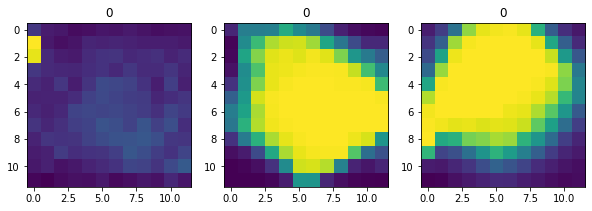

<Figure size 432x288 with 0 Axes>

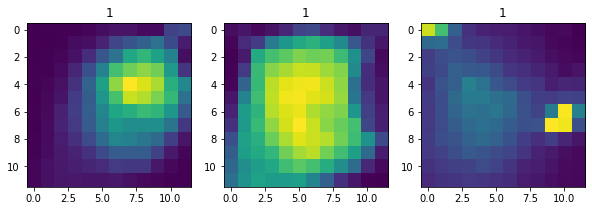

<Figure size 432x288 with 0 Axes>

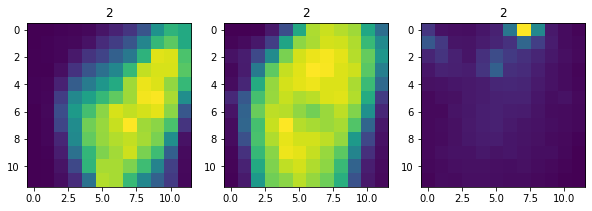

<Figure size 432x288 with 0 Axes>

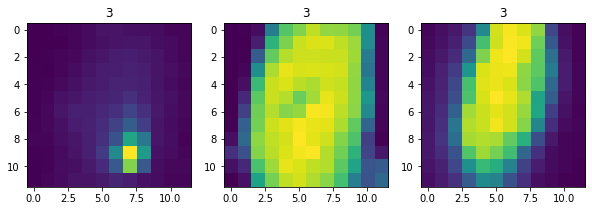

<Figure size 432x288 with 0 Axes>

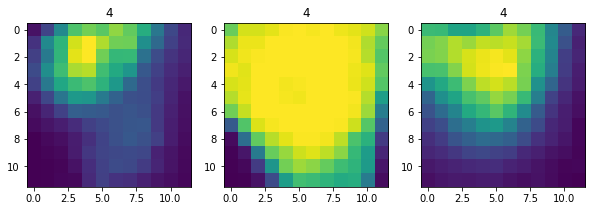

<Figure size 432x288 with 0 Axes>

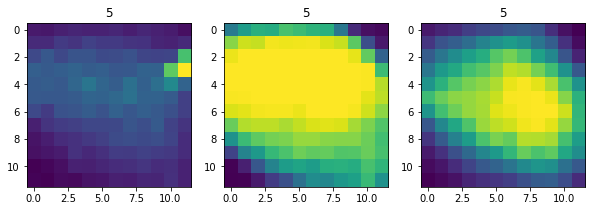

<Figure size 432x288 with 0 Axes>

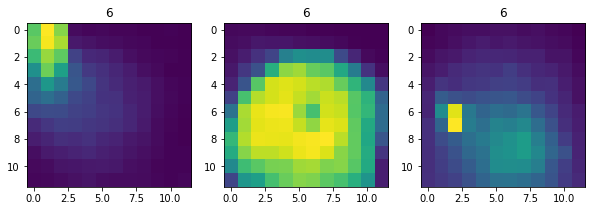

<Figure size 432x288 with 0 Axes>

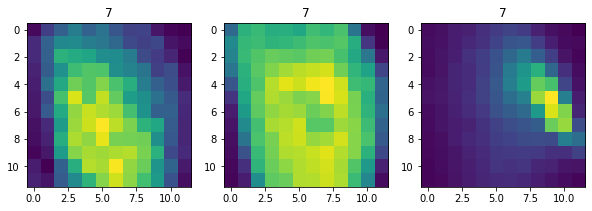

<Figure size 432x288 with 0 Axes>

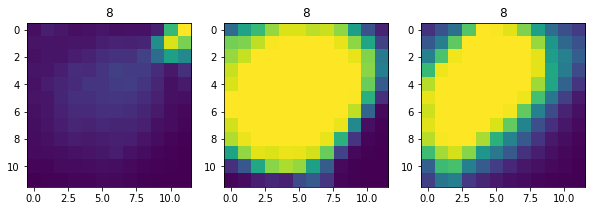

<Figure size 432x288 with 0 Axes>

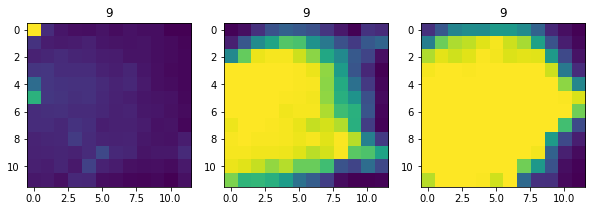

<Figure size 432x288 with 0 Axes>

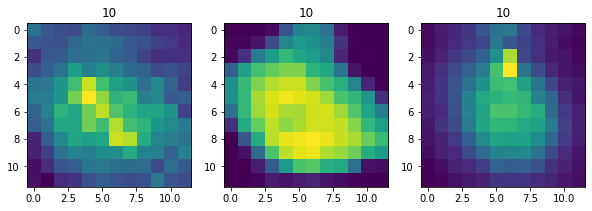

<Figure size 432x288 with 0 Axes>

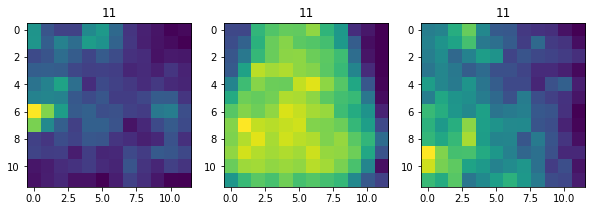

<Figure size 432x288 with 0 Axes>

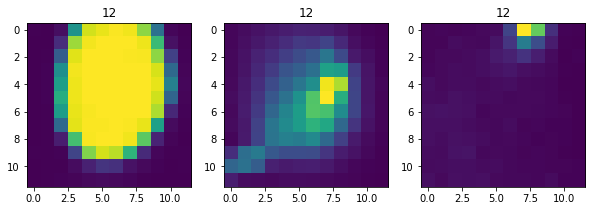

<Figure size 432x288 with 0 Axes>

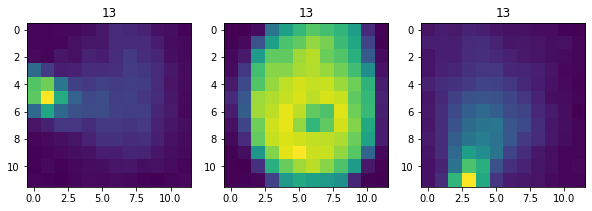

<Figure size 432x288 with 0 Axes>

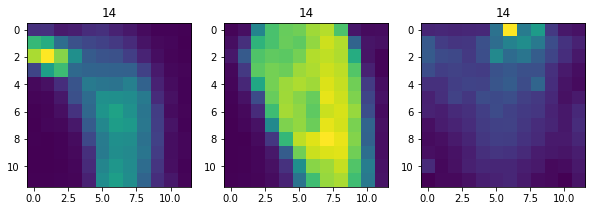

<Figure size 432x288 with 0 Axes>

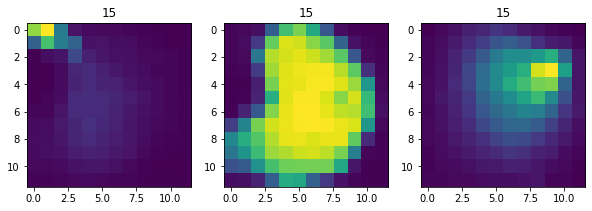

<Figure size 432x288 with 0 Axes>

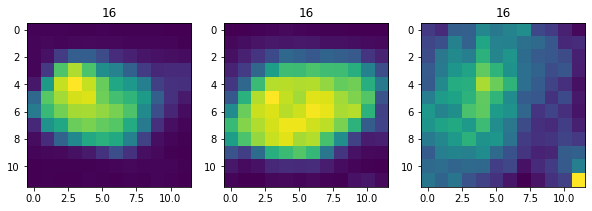

<Figure size 432x288 with 0 Axes>

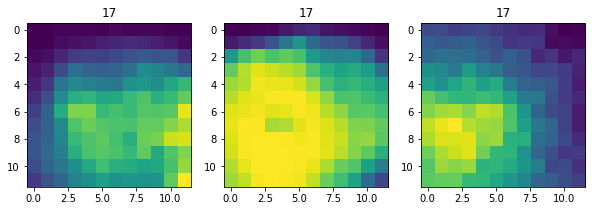

<Figure size 432x288 with 0 Axes>

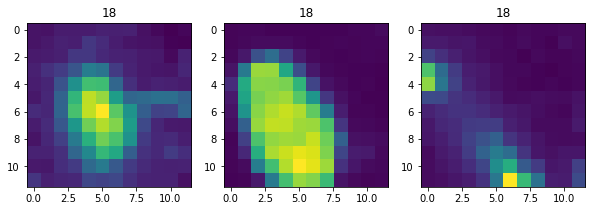

<Figure size 432x288 with 0 Axes>

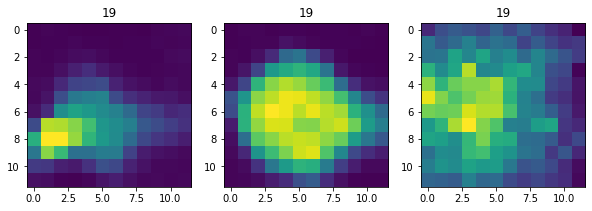

<Figure size 432x288 with 0 Axes>

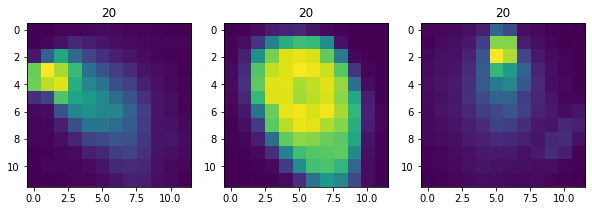

<Figure size 432x288 with 0 Axes>

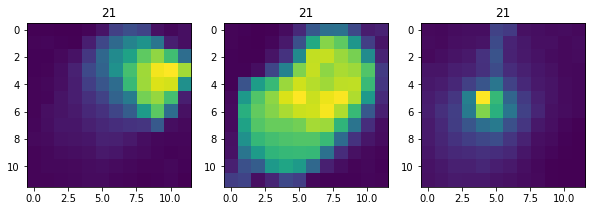

<Figure size 432x288 with 0 Axes>

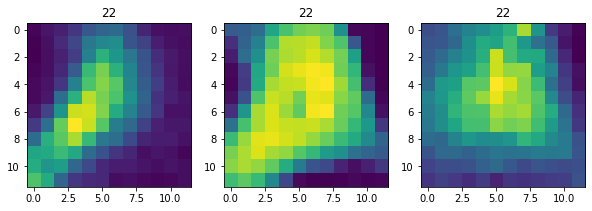

<Figure size 432x288 with 0 Axes>

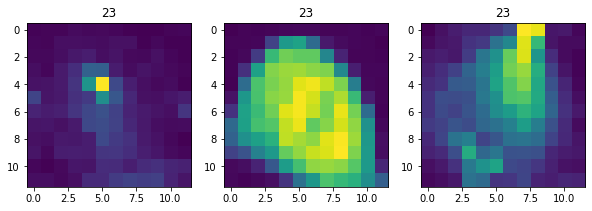

<Figure size 432x288 with 0 Axes>

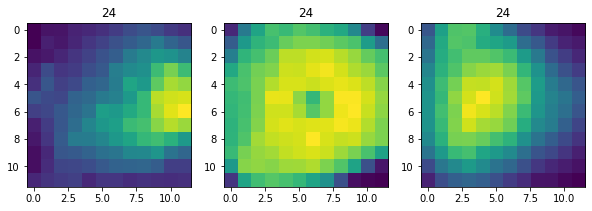

<Figure size 432x288 with 0 Axes>

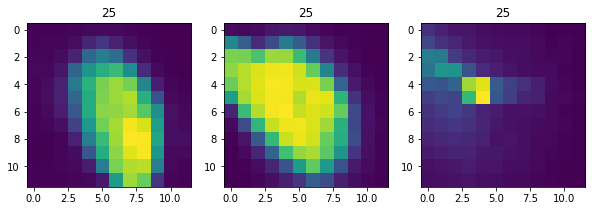

<Figure size 432x288 with 0 Axes>

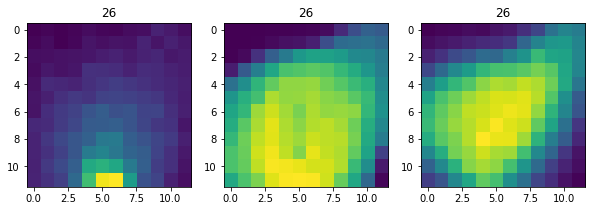

<Figure size 432x288 with 0 Axes>

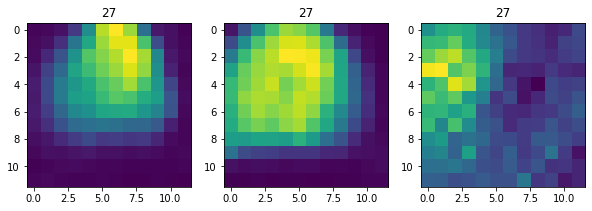

<Figure size 432x288 with 0 Axes>

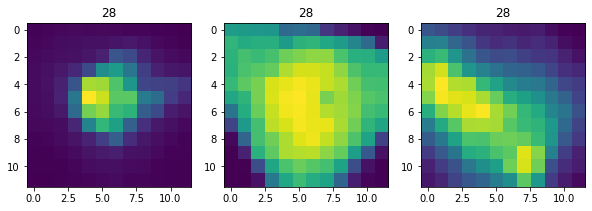

<Figure size 432x288 with 0 Axes>

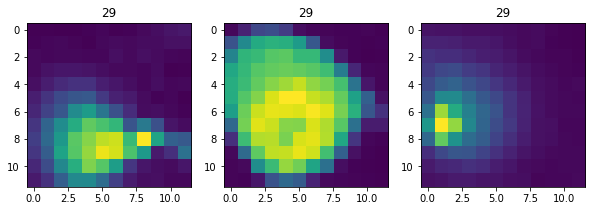

<Figure size 432x288 with 0 Axes>

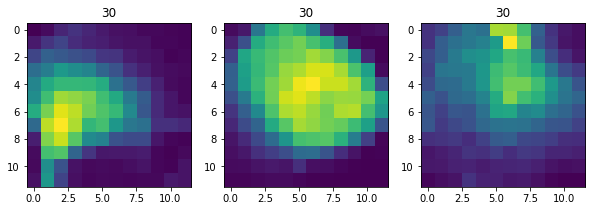

<Figure size 432x288 with 0 Axes>

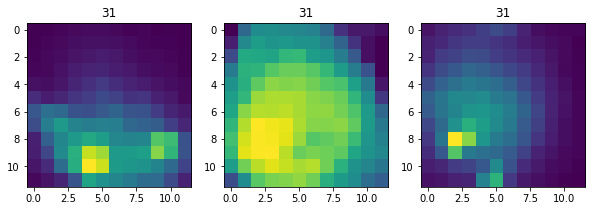

<Figure size 432x288 with 0 Axes>

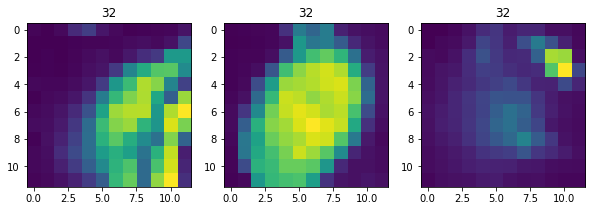

<Figure size 432x288 with 0 Axes>

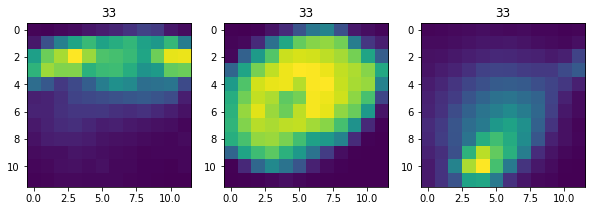

<Figure size 432x288 with 0 Axes>

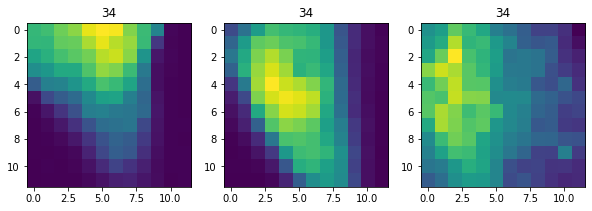

<Figure size 432x288 with 0 Axes>

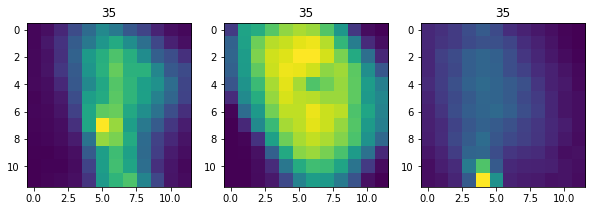

<Figure size 432x288 with 0 Axes>

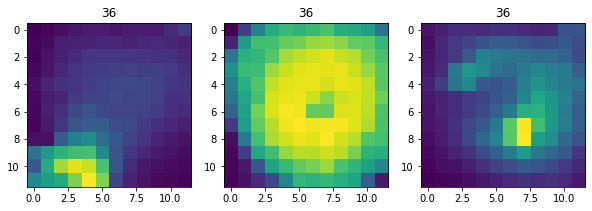

<Figure size 432x288 with 0 Axes>

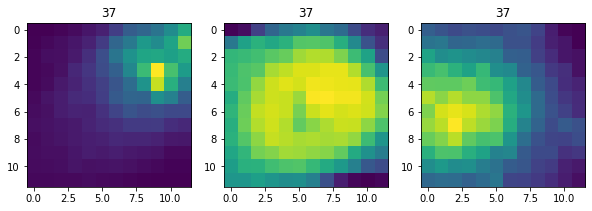

<Figure size 432x288 with 0 Axes>

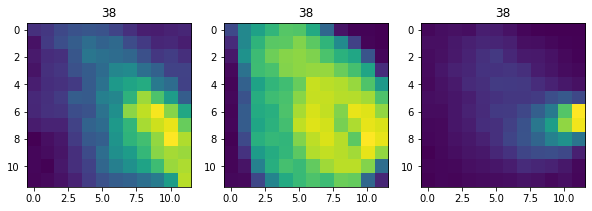

<Figure size 432x288 with 0 Axes>

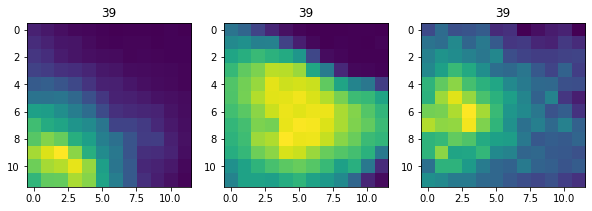

<Figure size 432x288 with 0 Axes>

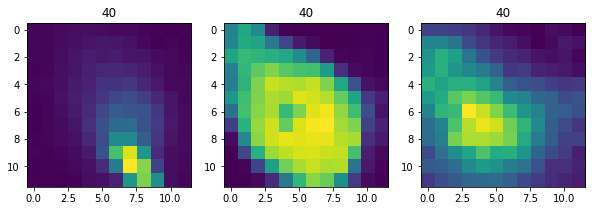

<Figure size 432x288 with 0 Axes>

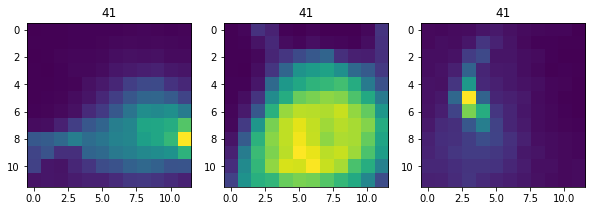

<Figure size 432x288 with 0 Axes>

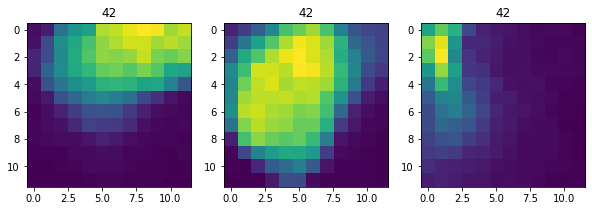

<Figure size 432x288 with 0 Axes>

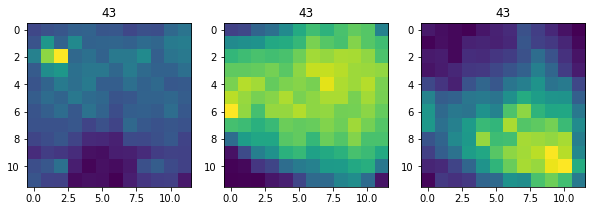

<Figure size 432x288 with 0 Axes>

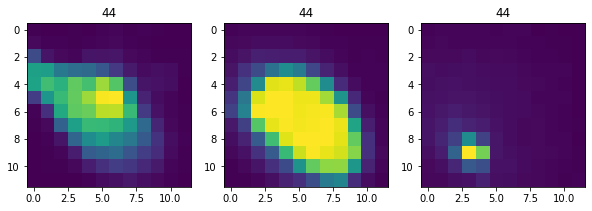

<Figure size 432x288 with 0 Axes>

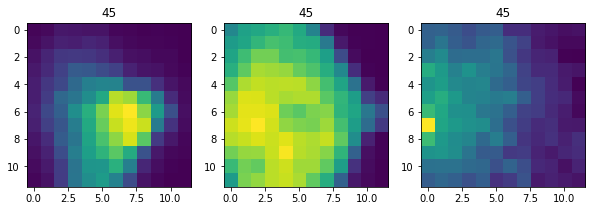

<Figure size 432x288 with 0 Axes>

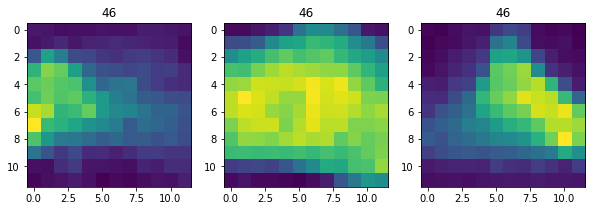

<Figure size 432x288 with 0 Axes>

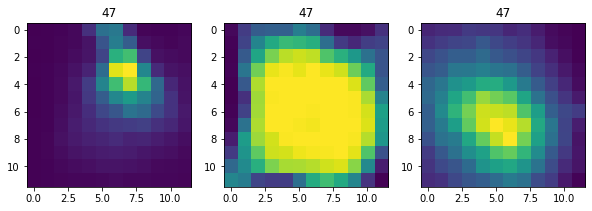

<Figure size 432x288 with 0 Axes>

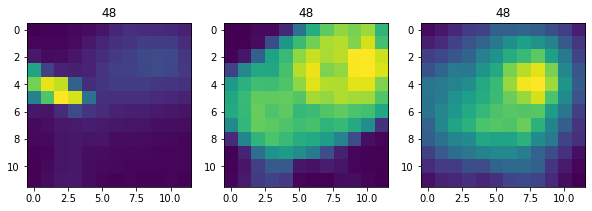

<Figure size 432x288 with 0 Axes>

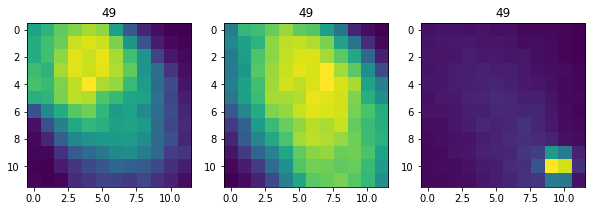

<Figure size 432x288 with 0 Axes>

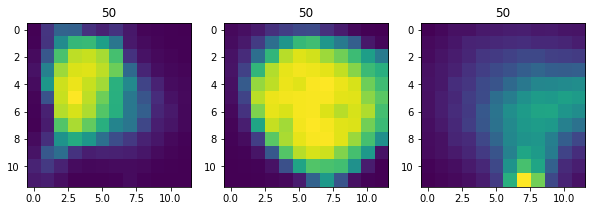

<Figure size 432x288 with 0 Axes>

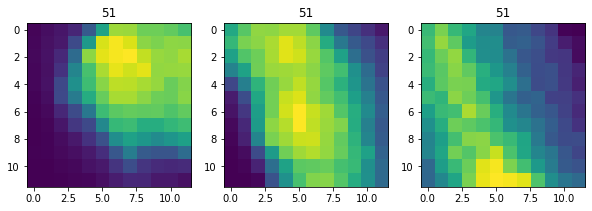

<Figure size 432x288 with 0 Axes>

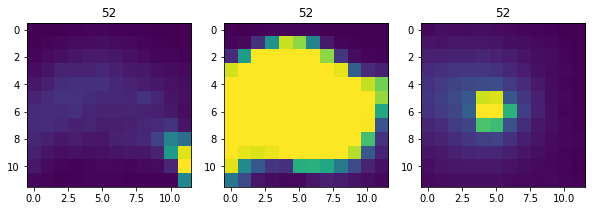

<Figure size 432x288 with 0 Axes>

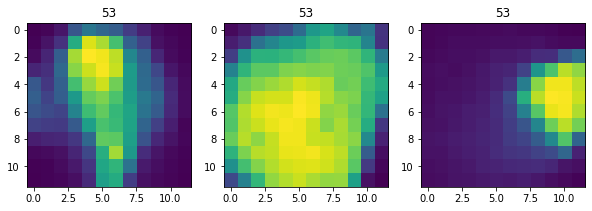

<Figure size 432x288 with 0 Axes>

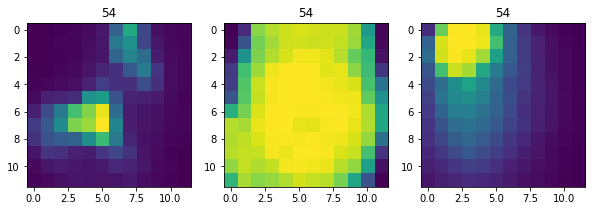

<Figure size 432x288 with 0 Axes>

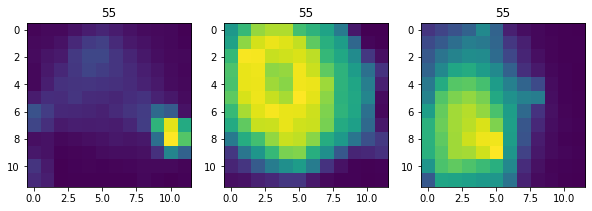

<Figure size 432x288 with 0 Axes>

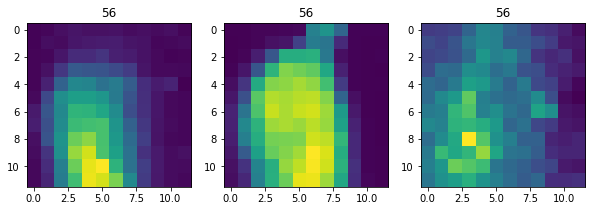

<Figure size 432x288 with 0 Axes>

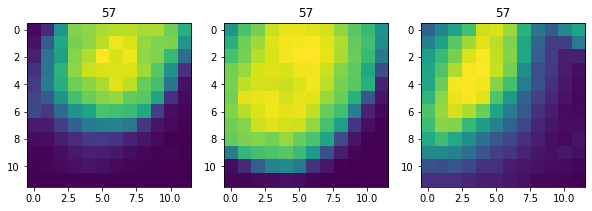

<Figure size 432x288 with 0 Axes>

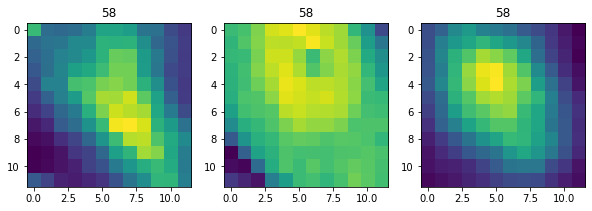

<Figure size 432x288 with 0 Axes>

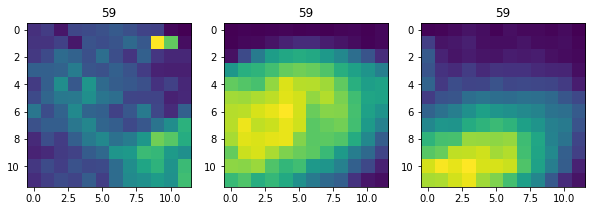

<Figure size 432x288 with 0 Axes>

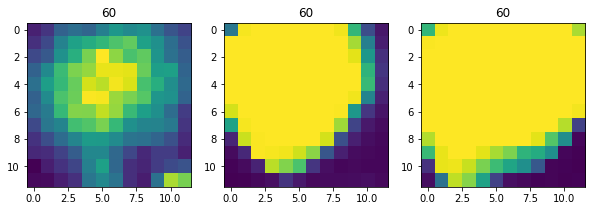

<Figure size 432x288 with 0 Axes>

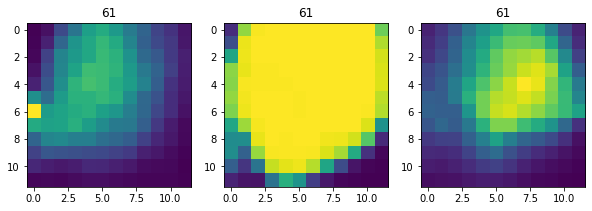

<Figure size 432x288 with 0 Axes>

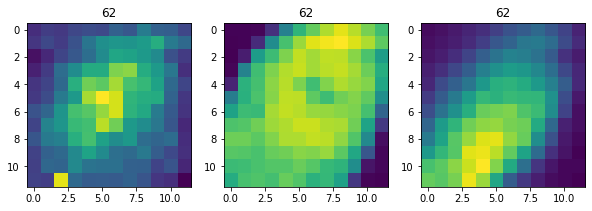

<Figure size 432x288 with 0 Axes>

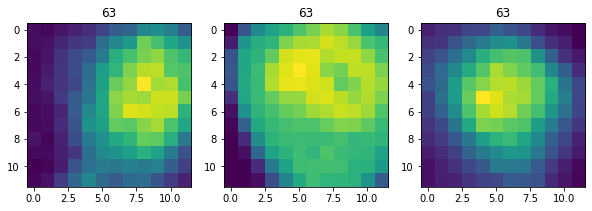

<Figure size 432x288 with 0 Axes>

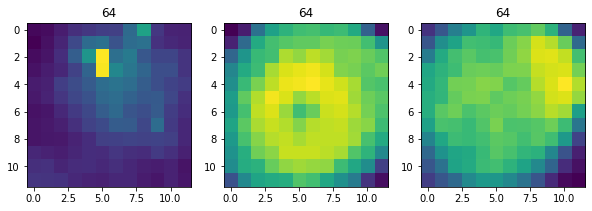

<Figure size 432x288 with 0 Axes>

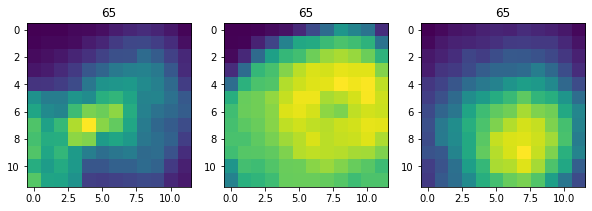

<Figure size 432x288 with 0 Axes>

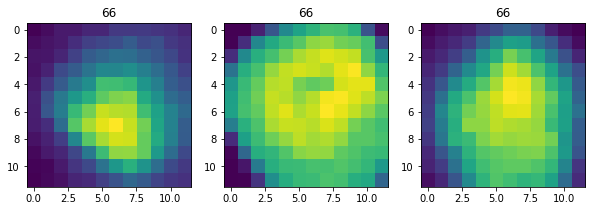

<Figure size 432x288 with 0 Axes>

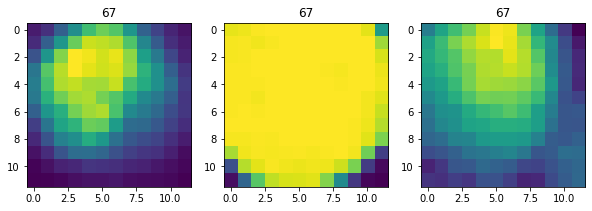

<Figure size 432x288 with 0 Axes>

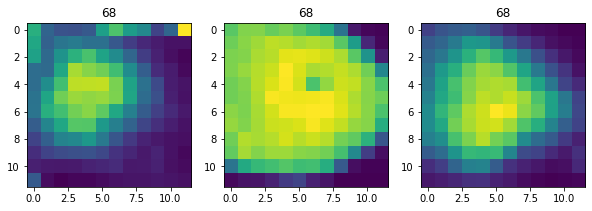

<Figure size 432x288 with 0 Axes>

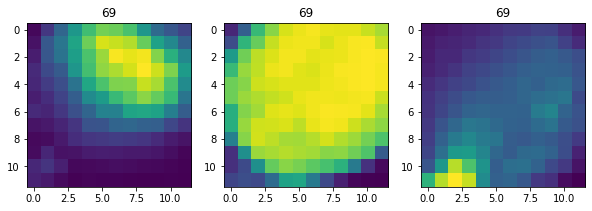

<Figure size 432x288 with 0 Axes>

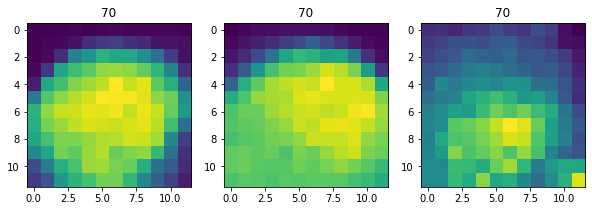

<Figure size 432x288 with 0 Axes>

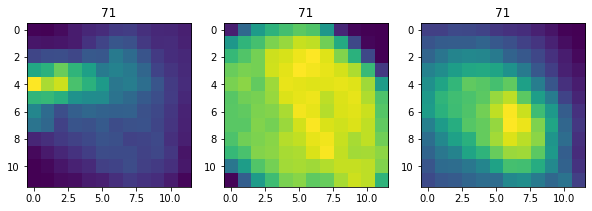

<Figure size 432x288 with 0 Axes>

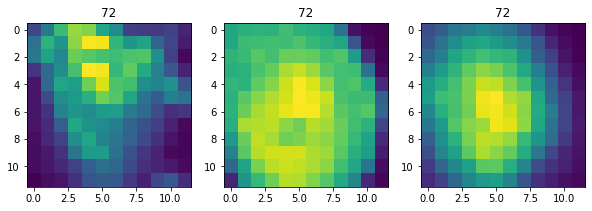

<Figure size 432x288 with 0 Axes>

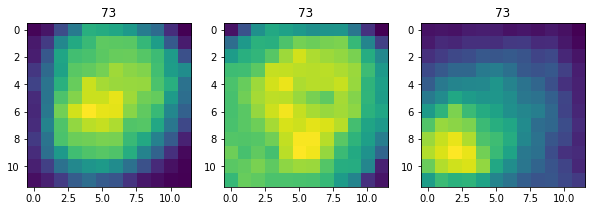

<Figure size 432x288 with 0 Axes>

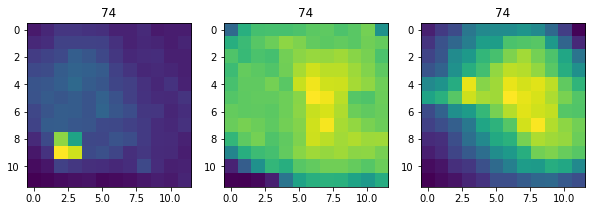

<Figure size 432x288 with 0 Axes>

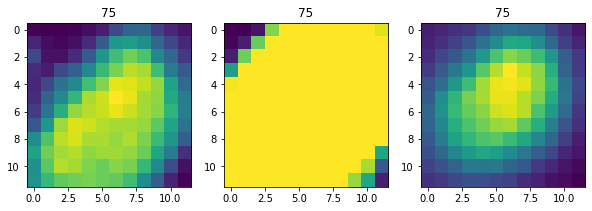

<Figure size 432x288 with 0 Axes>

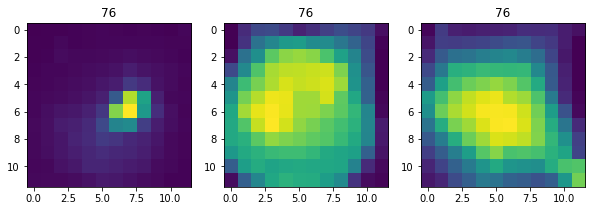

<Figure size 432x288 with 0 Axes>

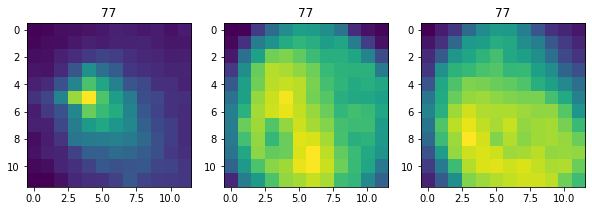

<Figure size 432x288 with 0 Axes>

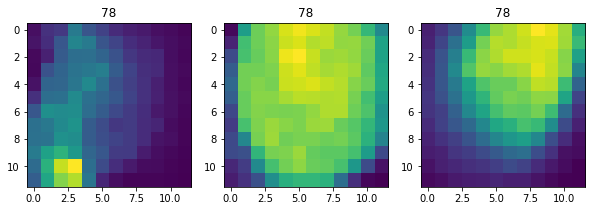

<Figure size 432x288 with 0 Axes>

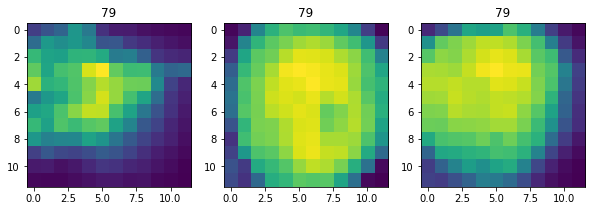

<Figure size 432x288 with 0 Axes>

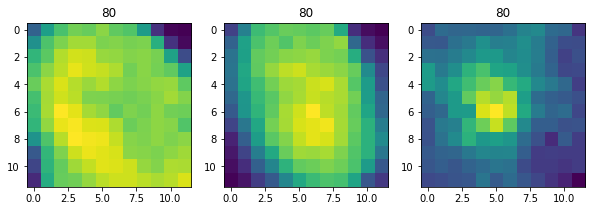

<Figure size 432x288 with 0 Axes>

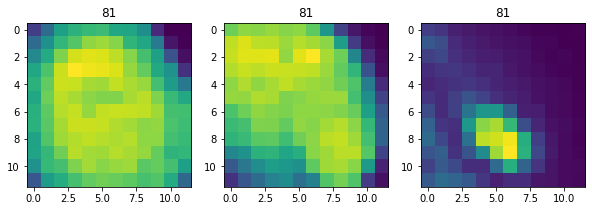

<Figure size 432x288 with 0 Axes>

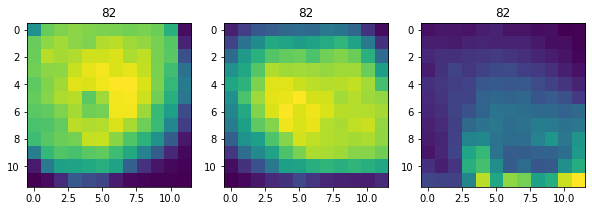

<Figure size 432x288 with 0 Axes>

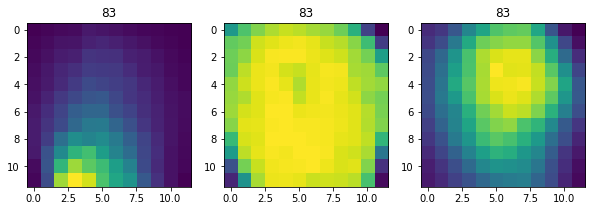

<Figure size 432x288 with 0 Axes>

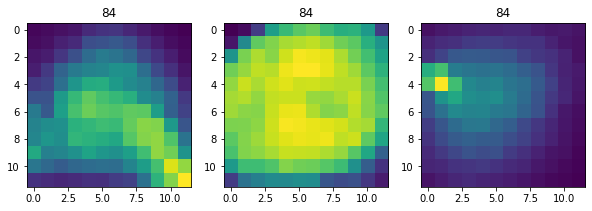

<Figure size 432x288 with 0 Axes>

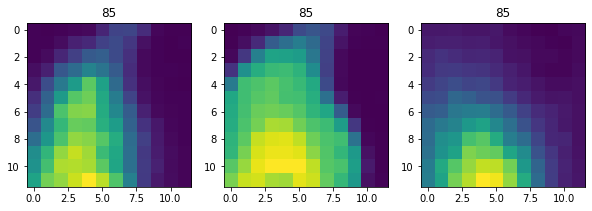

<Figure size 432x288 with 0 Axes>

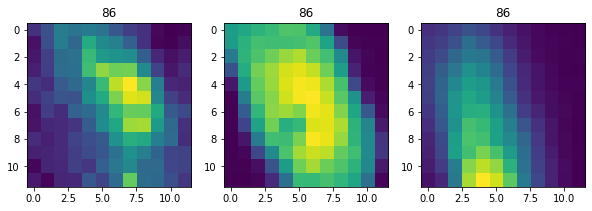

<Figure size 432x288 with 0 Axes>

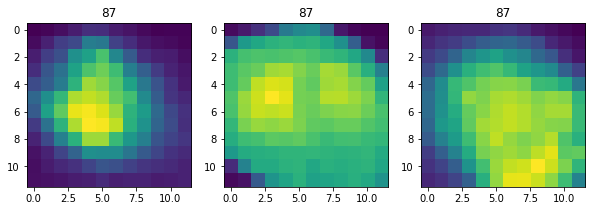

<Figure size 432x288 with 0 Axes>

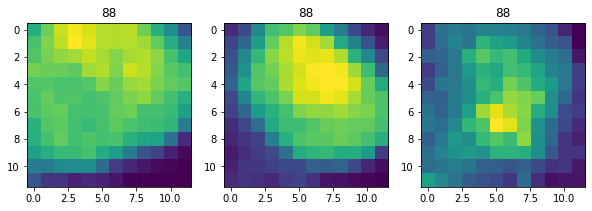

<Figure size 432x288 with 0 Axes>

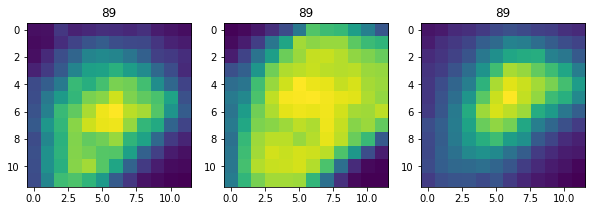

<Figure size 432x288 with 0 Axes>

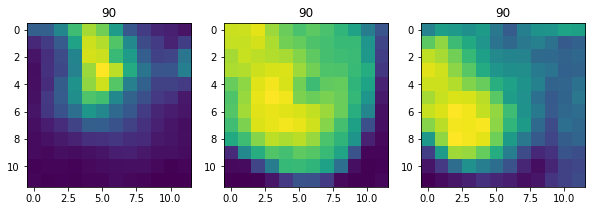

<Figure size 432x288 with 0 Axes>

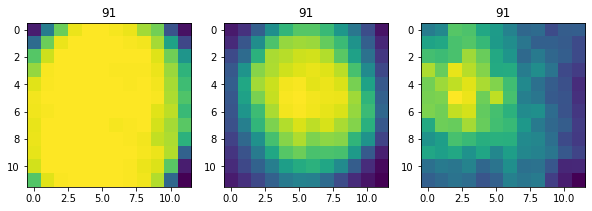

<Figure size 432x288 with 0 Axes>

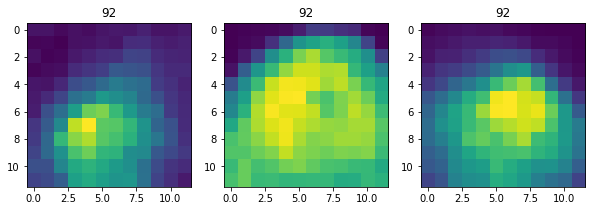

<Figure size 432x288 with 0 Axes>

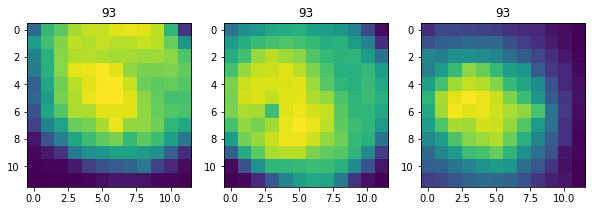

<Figure size 432x288 with 0 Axes>

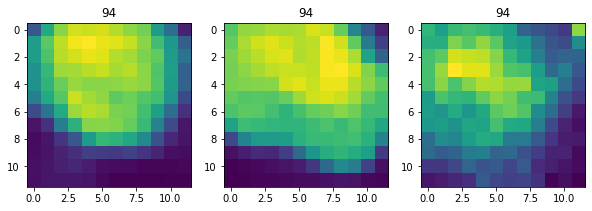

<Figure size 432x288 with 0 Axes>

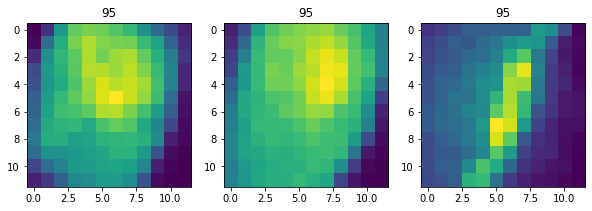

<Figure size 432x288 with 0 Axes>

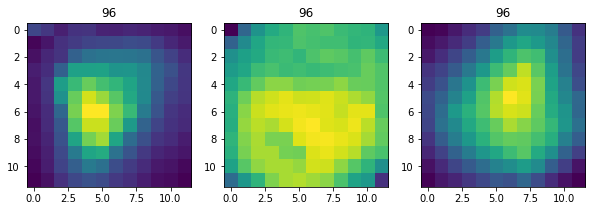

<Figure size 432x288 with 0 Axes>

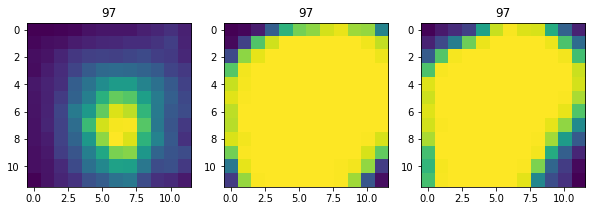

<Figure size 432x288 with 0 Axes>

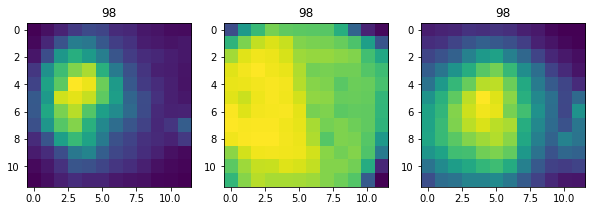

<Figure size 432x288 with 0 Axes>

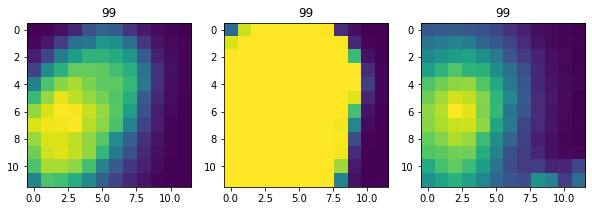

<Figure size 432x288 with 0 Axes>

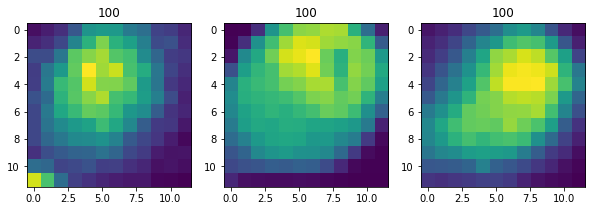

<Figure size 432x288 with 0 Axes>

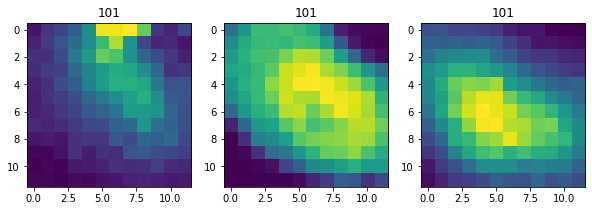

<Figure size 432x288 with 0 Axes>

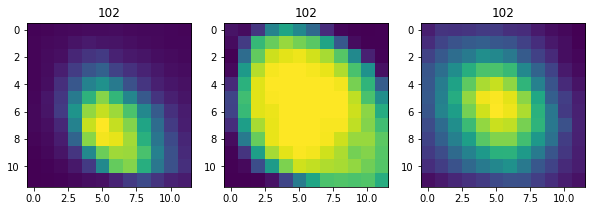

<Figure size 432x288 with 0 Axes>

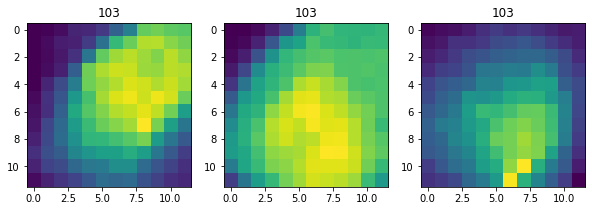

<Figure size 432x288 with 0 Axes>

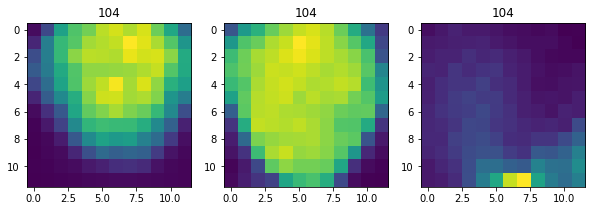

<Figure size 432x288 with 0 Axes>

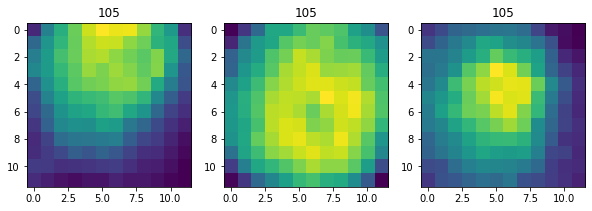

<Figure size 432x288 with 0 Axes>

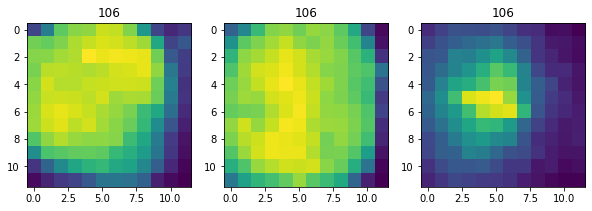

<Figure size 432x288 with 0 Axes>

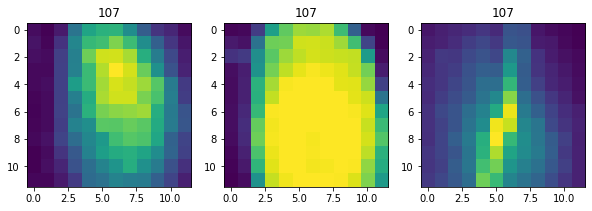

<Figure size 432x288 with 0 Axes>

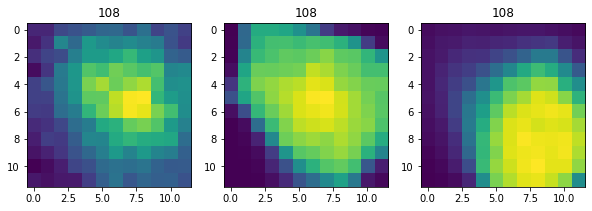

<Figure size 432x288 with 0 Axes>

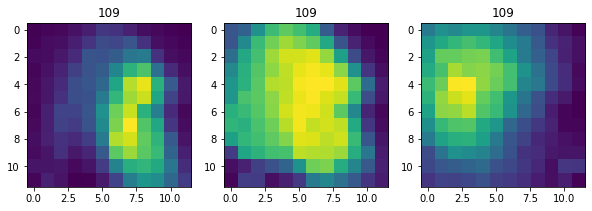

<Figure size 432x288 with 0 Axes>

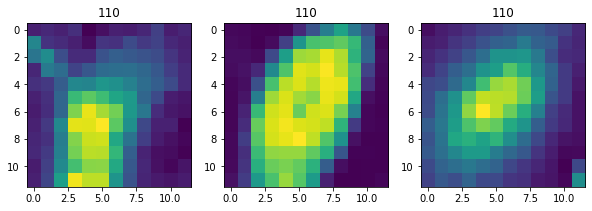

<Figure size 432x288 with 0 Axes>

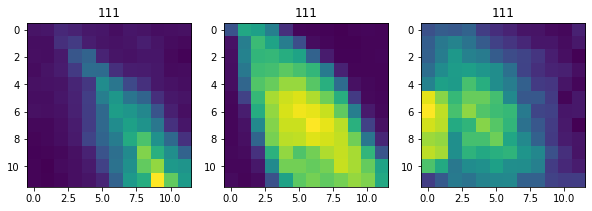

<Figure size 432x288 with 0 Axes>

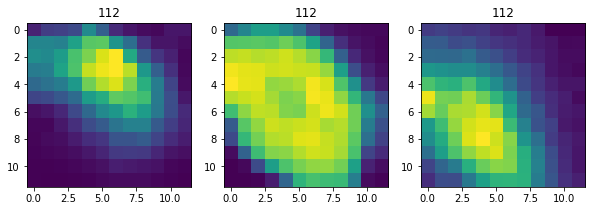

<Figure size 432x288 with 0 Axes>

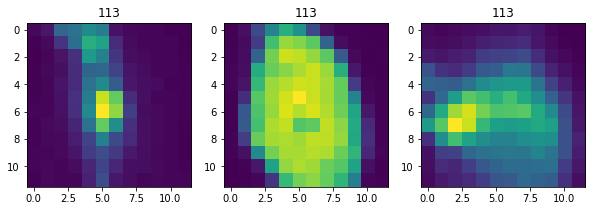

<Figure size 432x288 with 0 Axes>

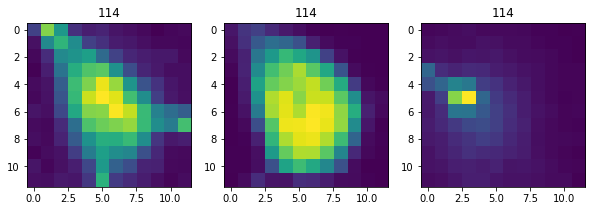

<Figure size 432x288 with 0 Axes>

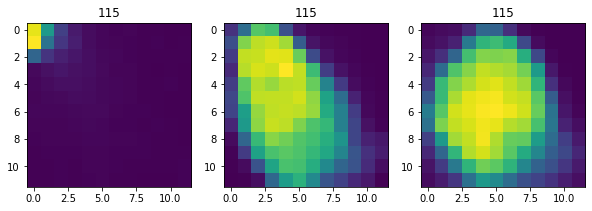

<Figure size 432x288 with 0 Axes>

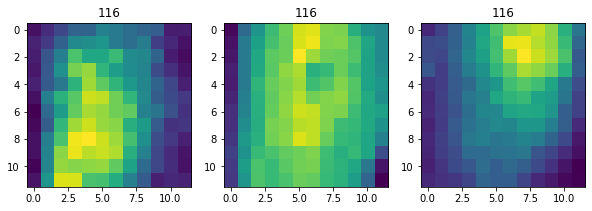

<Figure size 432x288 with 0 Axes>

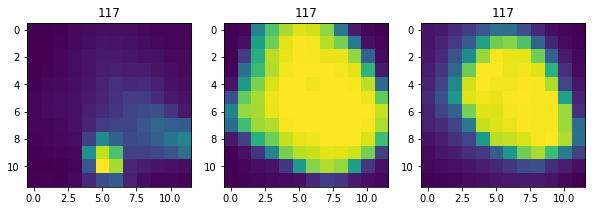

<Figure size 432x288 with 0 Axes>

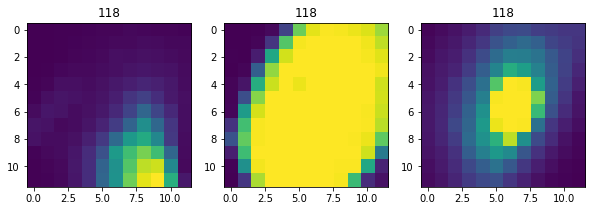

<Figure size 432x288 with 0 Axes>

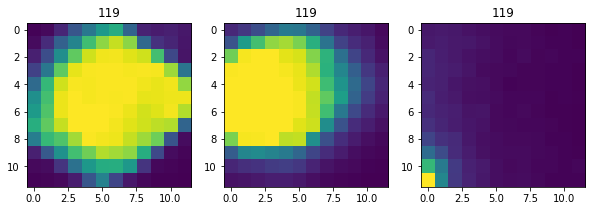

<Figure size 432x288 with 0 Axes>

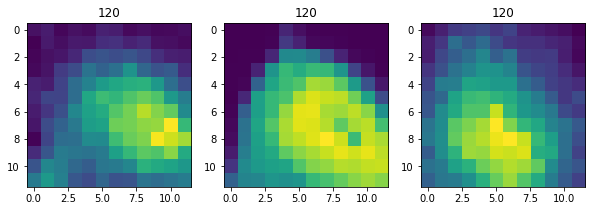

<Figure size 432x288 with 0 Axes>

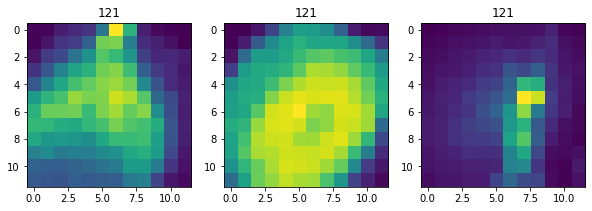

<Figure size 432x288 with 0 Axes>

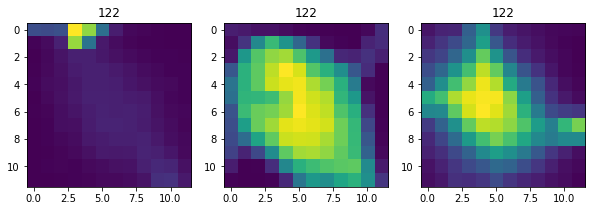

<Figure size 432x288 with 0 Axes>

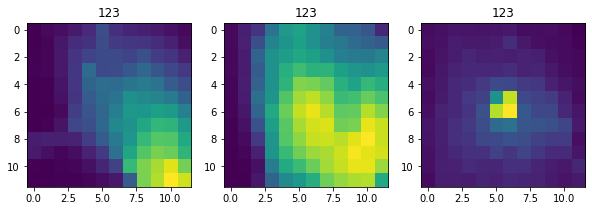

<Figure size 432x288 with 0 Axes>

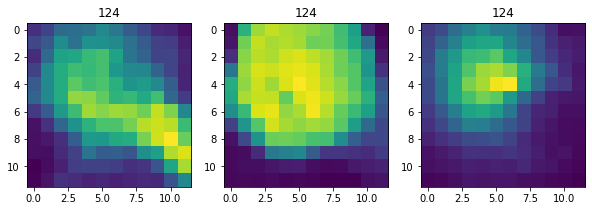

<Figure size 432x288 with 0 Axes>

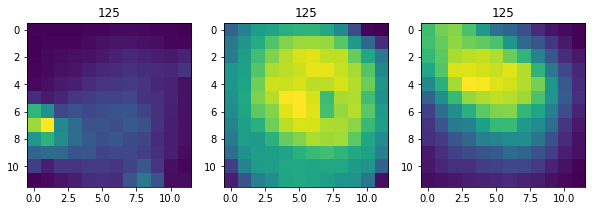

<Figure size 432x288 with 0 Axes>

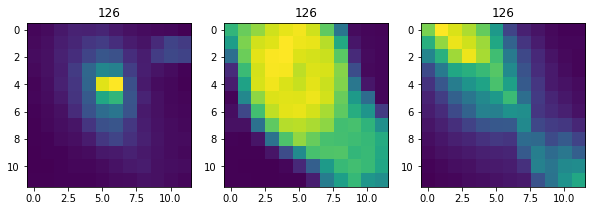

<Figure size 432x288 with 0 Axes>

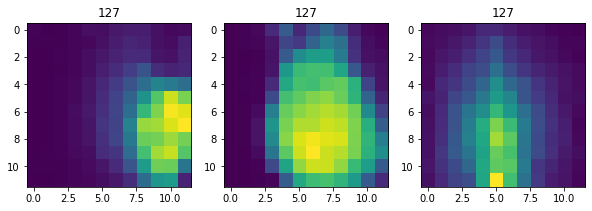

<Figure size 432x288 with 0 Axes>

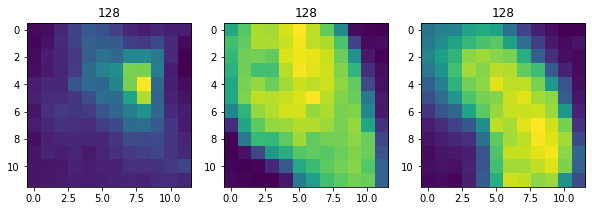

<Figure size 432x288 with 0 Axes>

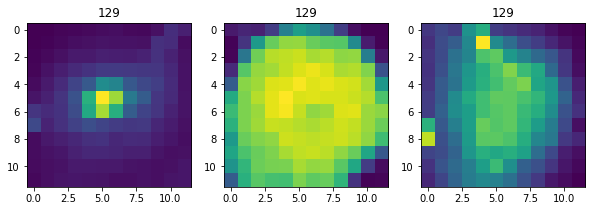

<Figure size 432x288 with 0 Axes>

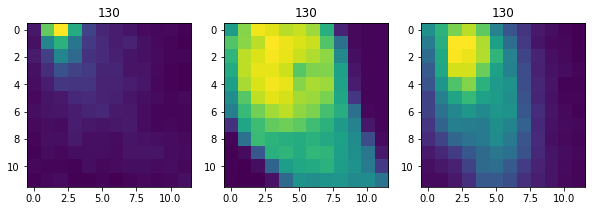

<Figure size 432x288 with 0 Axes>

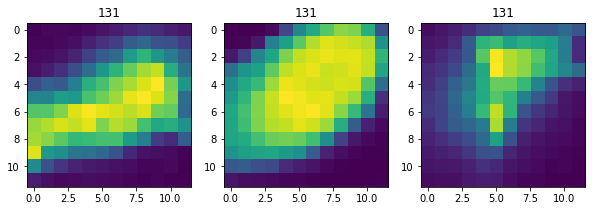

<Figure size 432x288 with 0 Axes>

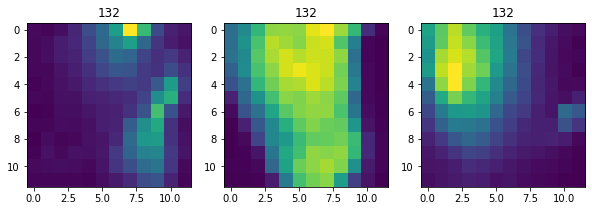

<Figure size 432x288 with 0 Axes>

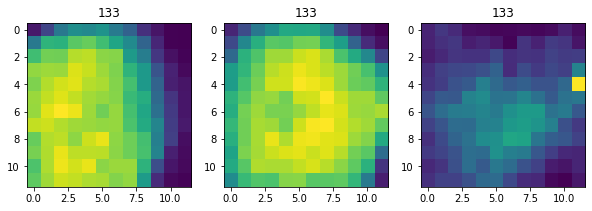

<Figure size 432x288 with 0 Axes>

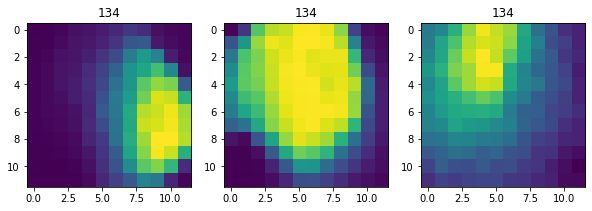

<Figure size 432x288 with 0 Axes>

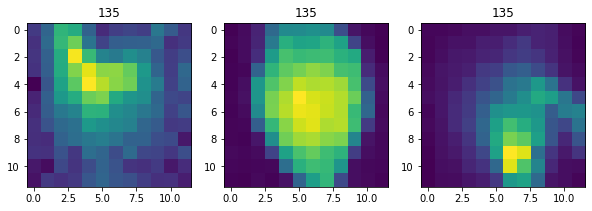

<Figure size 432x288 with 0 Axes>

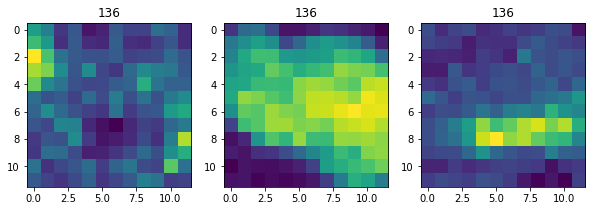

<Figure size 432x288 with 0 Axes>

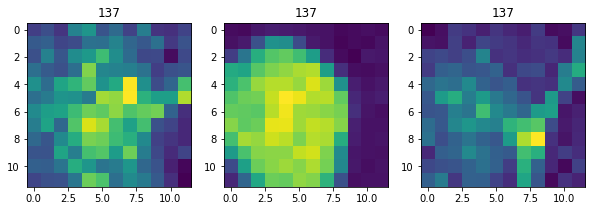

<Figure size 432x288 with 0 Axes>

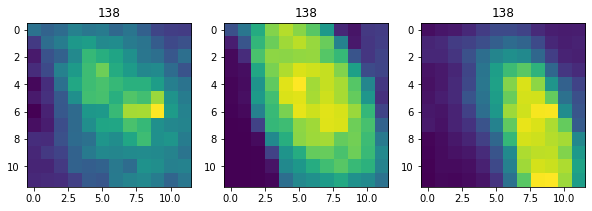

<Figure size 432x288 with 0 Axes>

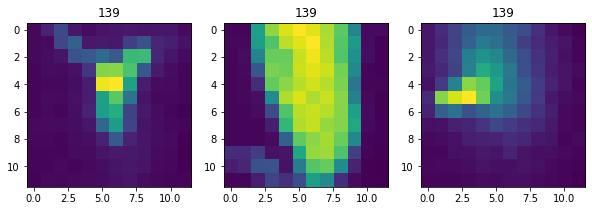

<Figure size 432x288 with 0 Axes>

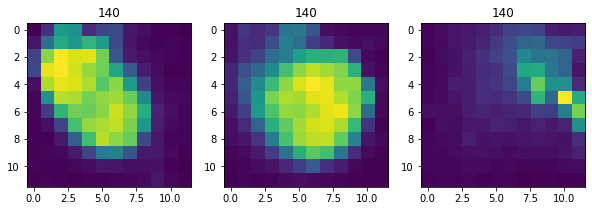

<Figure size 432x288 with 0 Axes>

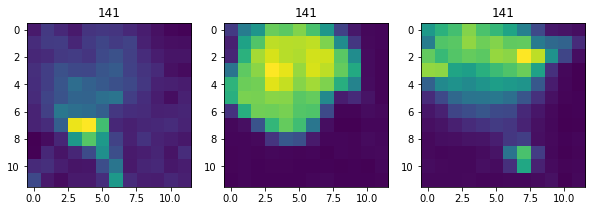

<Figure size 432x288 with 0 Axes>

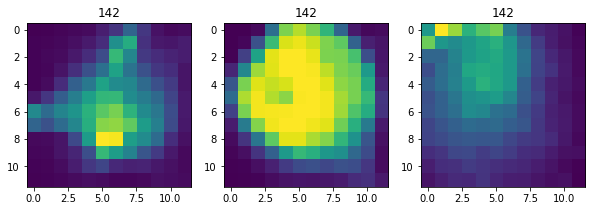

<Figure size 432x288 with 0 Axes>

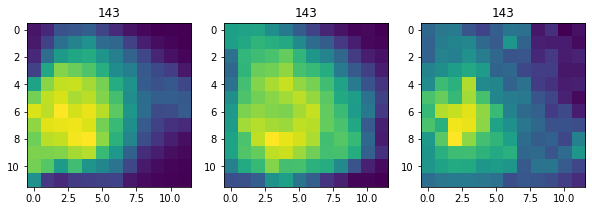

<Figure size 432x288 with 0 Axes>

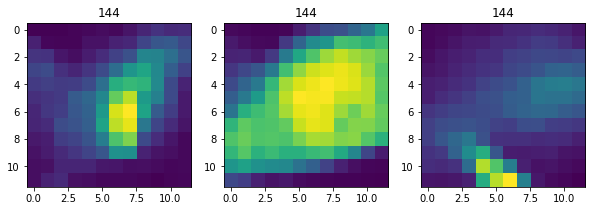

<Figure size 432x288 with 0 Axes>

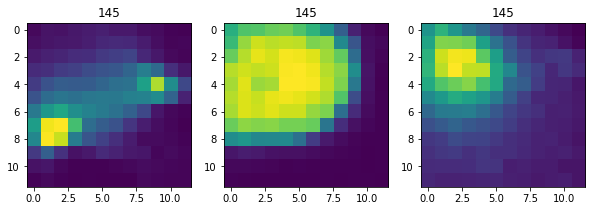

<Figure size 432x288 with 0 Axes>

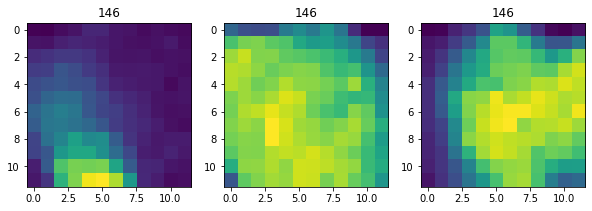

<Figure size 432x288 with 0 Axes>

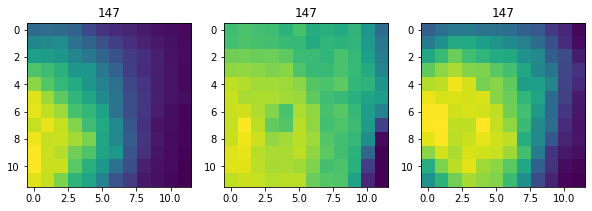

<Figure size 432x288 with 0 Axes>

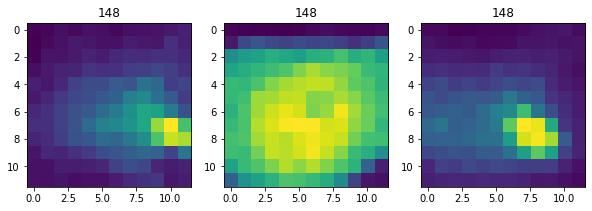

<Figure size 432x288 with 0 Axes>

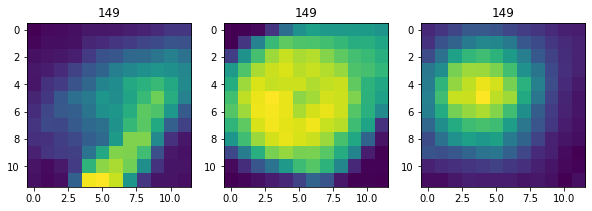

<Figure size 432x288 with 0 Axes>

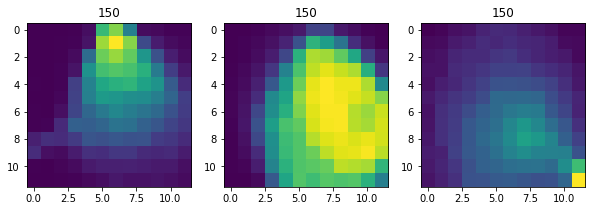

<Figure size 432x288 with 0 Axes>

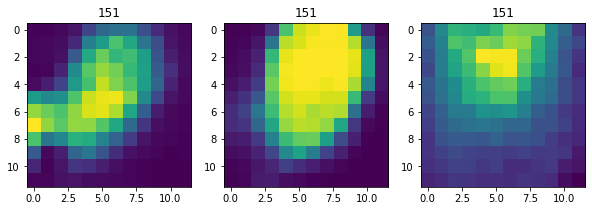

<Figure size 432x288 with 0 Axes>

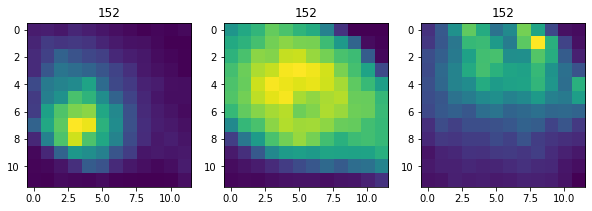

<Figure size 432x288 with 0 Axes>

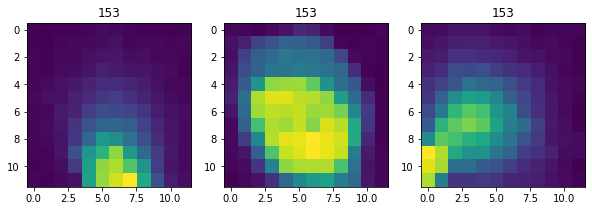

<Figure size 432x288 with 0 Axes>

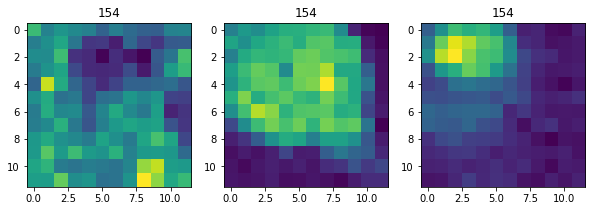

<Figure size 432x288 with 0 Axes>

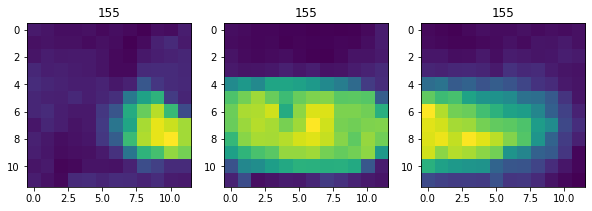

<Figure size 432x288 with 0 Axes>

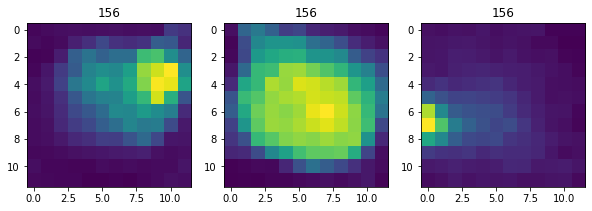

<Figure size 432x288 with 0 Axes>

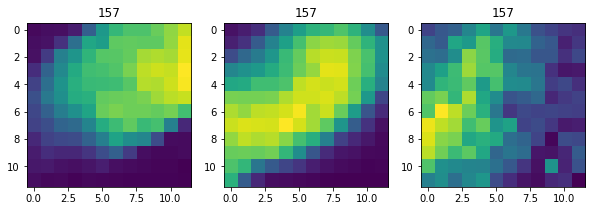

<Figure size 432x288 with 0 Axes>

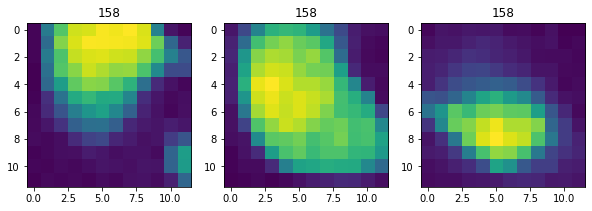

<Figure size 432x288 with 0 Axes>

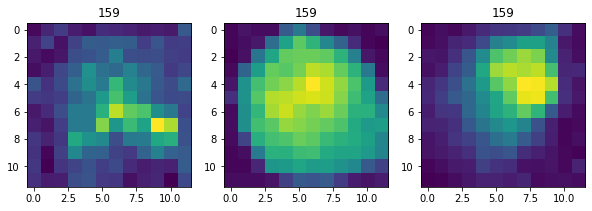

<Figure size 432x288 with 0 Axes>

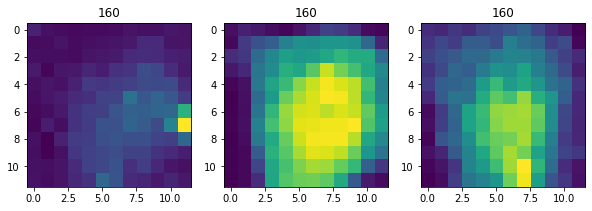

<Figure size 432x288 with 0 Axes>

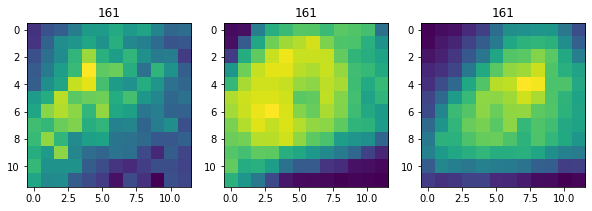

<Figure size 432x288 with 0 Axes>

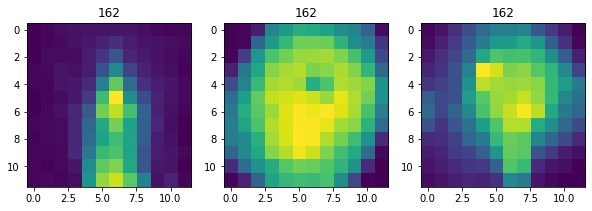

<Figure size 432x288 with 0 Axes>

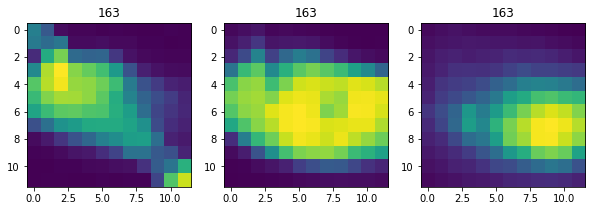

<Figure size 432x288 with 0 Axes>

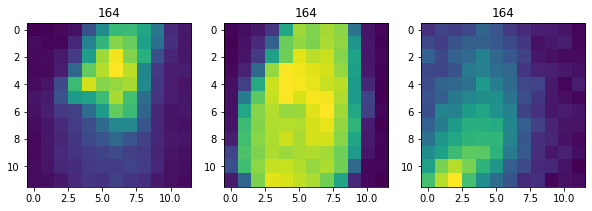

<Figure size 432x288 with 0 Axes>

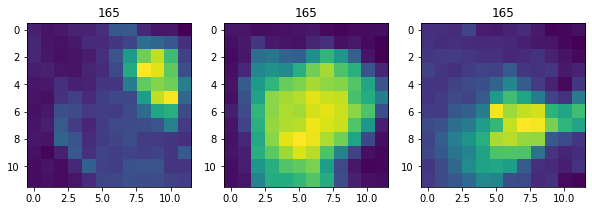

<Figure size 432x288 with 0 Axes>

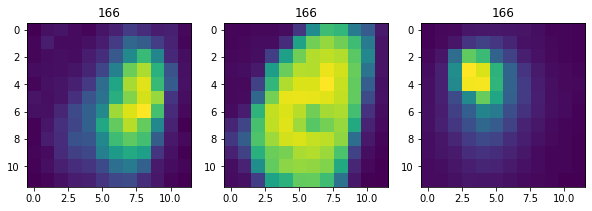

<Figure size 432x288 with 0 Axes>

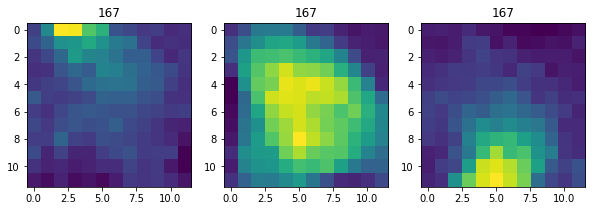

<Figure size 432x288 with 0 Axes>

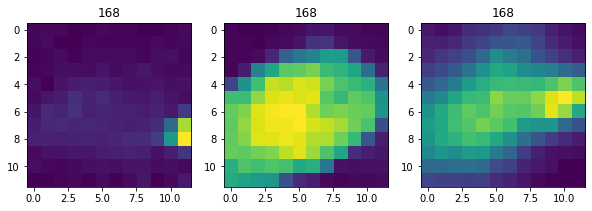

<Figure size 432x288 with 0 Axes>

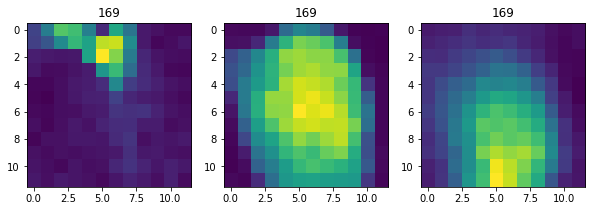

<Figure size 432x288 with 0 Axes>

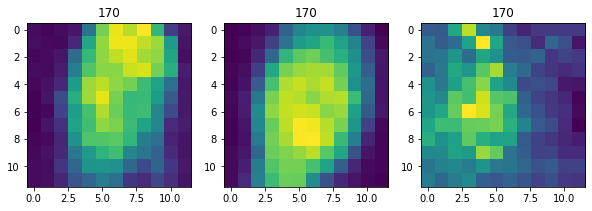

<Figure size 432x288 with 0 Axes>

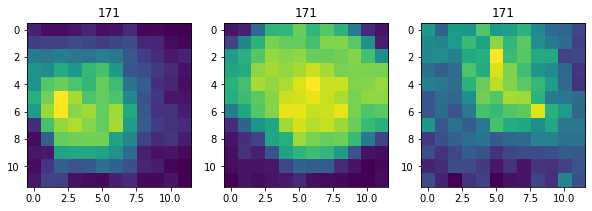

<Figure size 432x288 with 0 Axes>

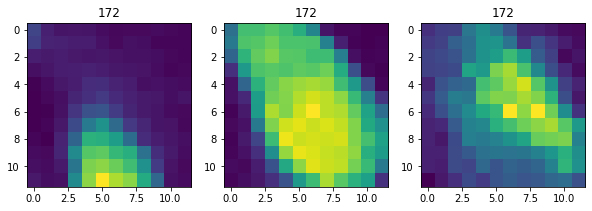

<Figure size 432x288 with 0 Axes>

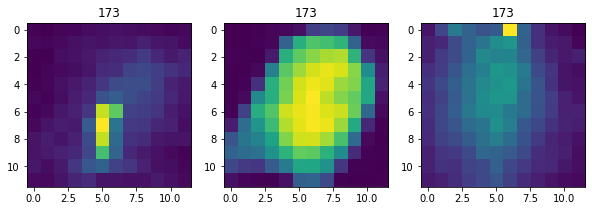

<Figure size 432x288 with 0 Axes>

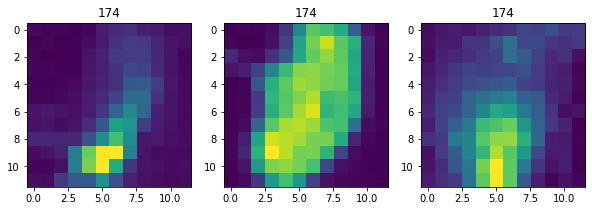

<Figure size 432x288 with 0 Axes>

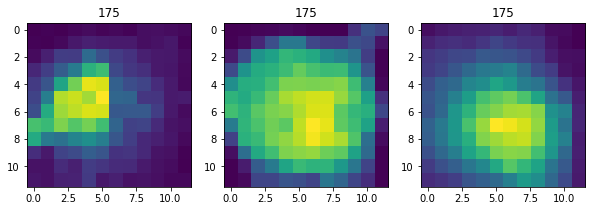

<Figure size 432x288 with 0 Axes>

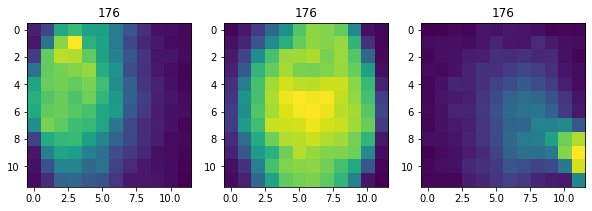

<Figure size 432x288 with 0 Axes>

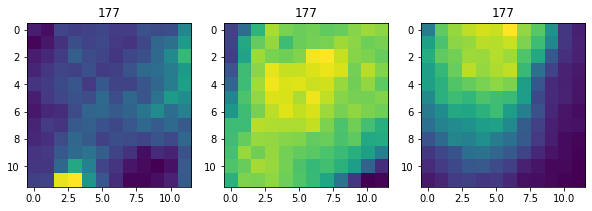

<Figure size 432x288 with 0 Axes>

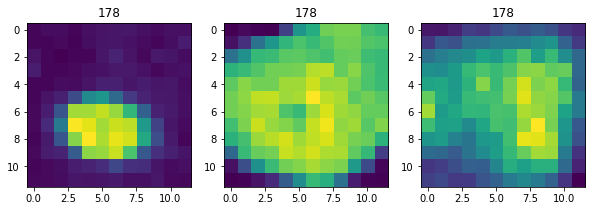

<Figure size 432x288 with 0 Axes>

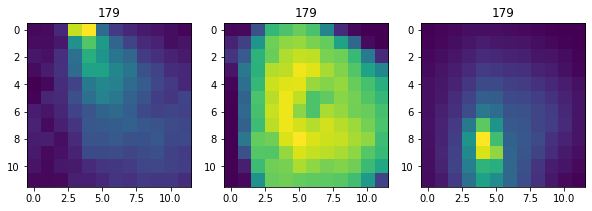

In [11]:
for i in range(len(imgs)):
    fig = plt.figure()
    f, axarr = plt.subplots(1,3, figsize=(10,10) ) 
    axarr[0].set_title(i); axarr[1].set_title(i); axarr[2].set_title(i)

    axarr[0].imshow(imgs[i][:,:,3])
    axarr[1].imshow(imgs[i][:,:,6])
    axarr[2].imshow(imgs[i][:,:,9])

## Closely insepct any suspicious regions in napari 

In [57]:
%gui qt
i = 90
path = paths[i]
with napari.gui_qt():
    viewer = napari.Viewer(ndisplay=3)
    viewer.add_image( imgs[i] )
    viewer.add_shapes(data=path, shape_type='path', edge_width=0.1, edge_color='blue', opacity=0.1)
    viewer.add_points([radius,radius,radius], size=1, opacity=0.5)

## Save stack of ROI subvolumes

In [60]:
np.save('ROI_all_bias_corrected.npy', imgs)

# *Generate NCR subvolumes for testing*

## Identify a voxel that is 'offset' number of voxels away from a cell center and pull a subvolume of NCR data around that voxel

In [14]:
%%capture
dir = "s3://open-neurodata/brainlit/brain1"
dir_segments = "s3://open-neurodata/brainlit/brain1_segments"
mip = 2
radius = 6
v_id = 0
offset = radius*2

# Create a list of imgs for each cell in 'dir' using 'pull_voxel'
NCR_imgs = []
ngl_sess = NeuroglancerSession(mip=mip, url=dir, url_segments=dir_segments)
for seg_id in range(1000):
    try:
        # Get cell center location (0th voxel coordinates)
        img, bbox, vox = ngl_sess.pull_voxel(seg_id, v_id, radius) 
        img_off = ngl_sess.pull_bounds_img(bbox + offset)
        print(f"\n\nDownloaded volume is of shape {img_off.shape}, with individual total intensities of {sum(sum(sum(img)))}.")
        NCR_imgs.append(img_off)
    except:
        pass


## Subvolume size must be 12x12x12 so remove a pixel from each dimension 

In [17]:
for i in range(180):
    NCR_imgs[i] = NCR_imgs[i][:12,:12,:12]

## Manually inspect data to confirm absence of cells

<Figure size 432x288 with 0 Axes>

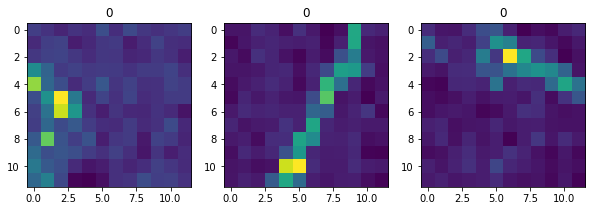

<Figure size 432x288 with 0 Axes>

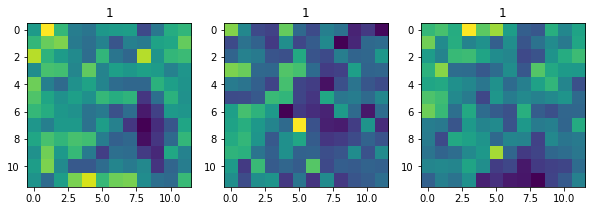

<Figure size 432x288 with 0 Axes>

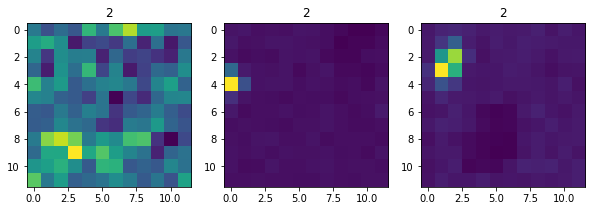

<Figure size 432x288 with 0 Axes>

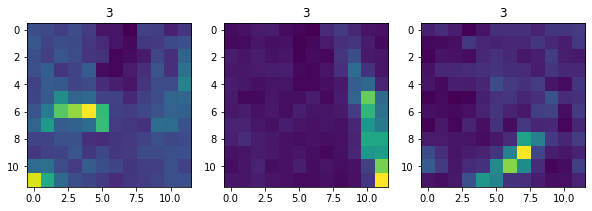

<Figure size 432x288 with 0 Axes>

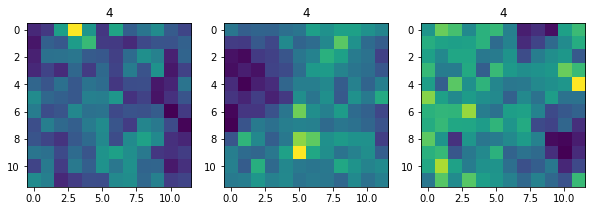

<Figure size 432x288 with 0 Axes>

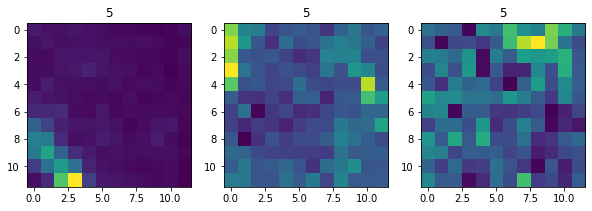

<Figure size 432x288 with 0 Axes>

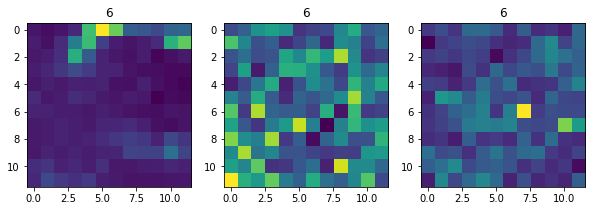

<Figure size 432x288 with 0 Axes>

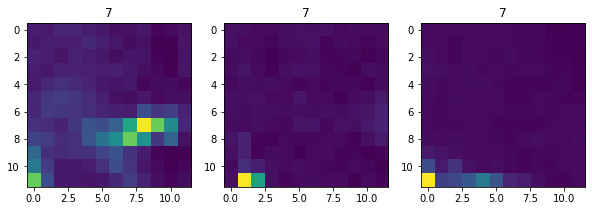

<Figure size 432x288 with 0 Axes>

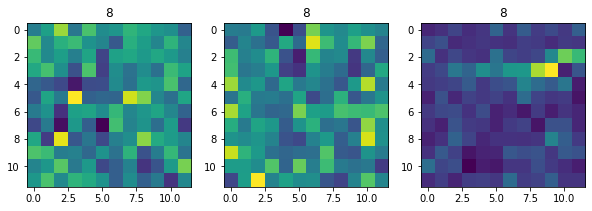

<Figure size 432x288 with 0 Axes>

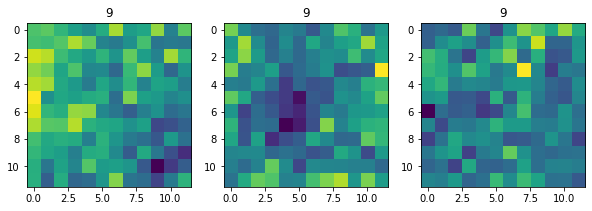

<Figure size 432x288 with 0 Axes>

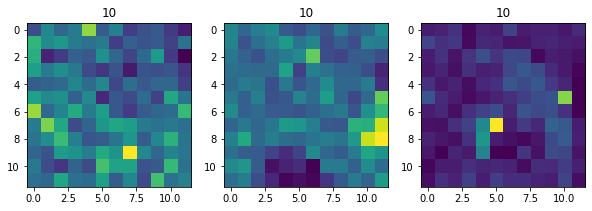

<Figure size 432x288 with 0 Axes>

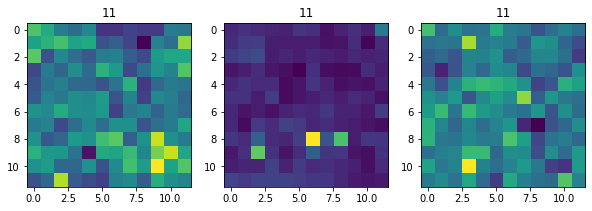

<Figure size 432x288 with 0 Axes>

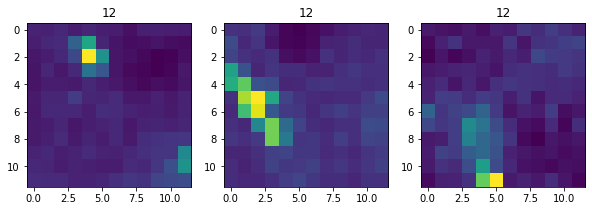

<Figure size 432x288 with 0 Axes>

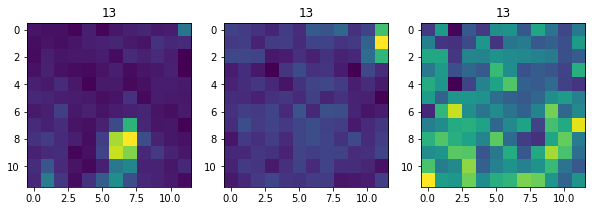

<Figure size 432x288 with 0 Axes>

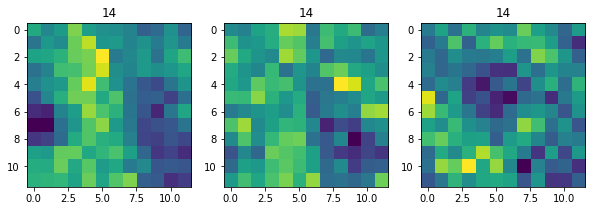

<Figure size 432x288 with 0 Axes>

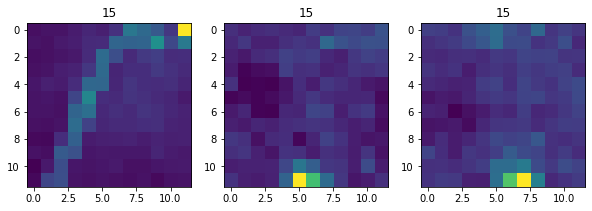

<Figure size 432x288 with 0 Axes>

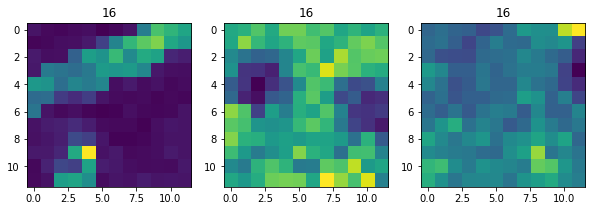

<Figure size 432x288 with 0 Axes>

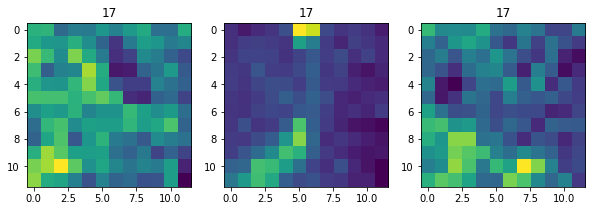

<Figure size 432x288 with 0 Axes>

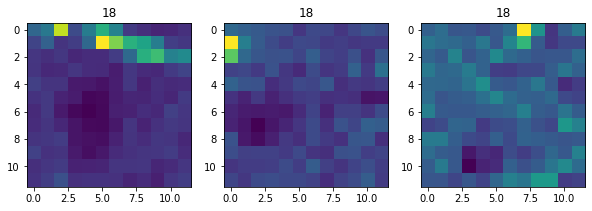

<Figure size 432x288 with 0 Axes>

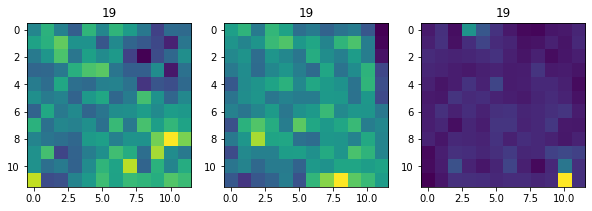

<Figure size 432x288 with 0 Axes>

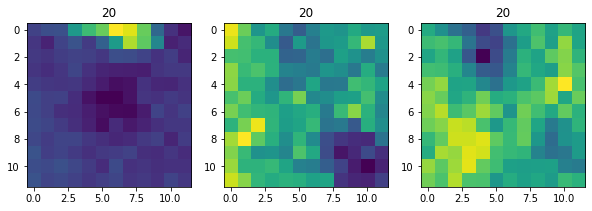

<Figure size 432x288 with 0 Axes>

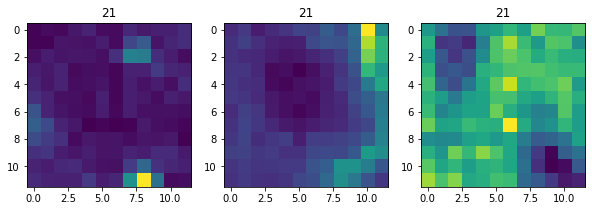

<Figure size 432x288 with 0 Axes>

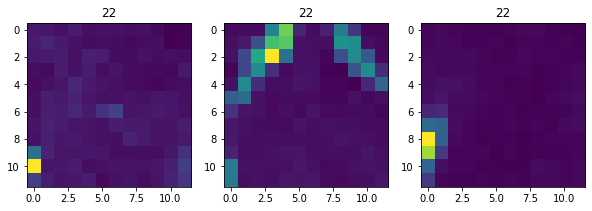

<Figure size 432x288 with 0 Axes>

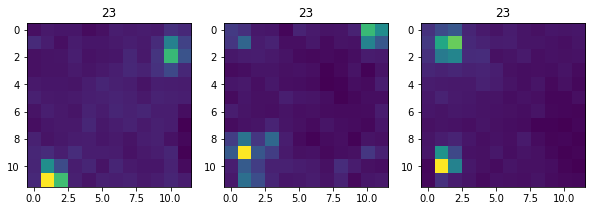

<Figure size 432x288 with 0 Axes>

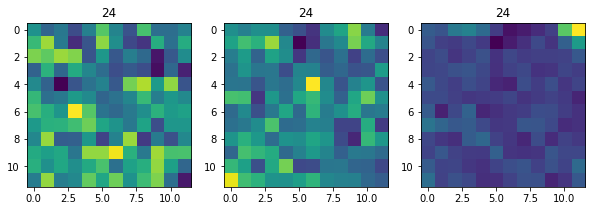

<Figure size 432x288 with 0 Axes>

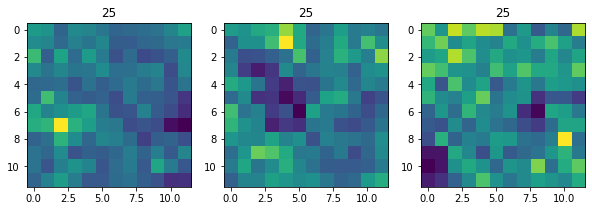

<Figure size 432x288 with 0 Axes>

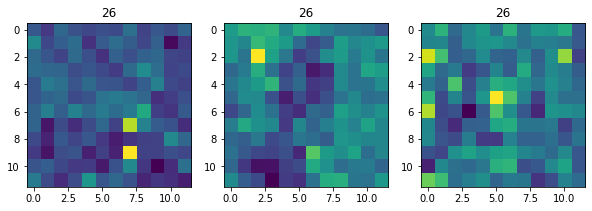

<Figure size 432x288 with 0 Axes>

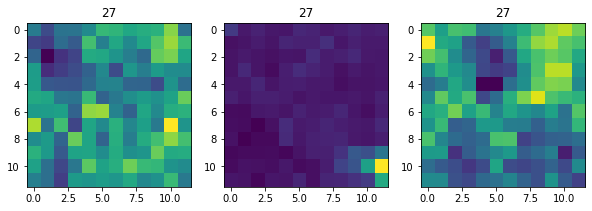

<Figure size 432x288 with 0 Axes>

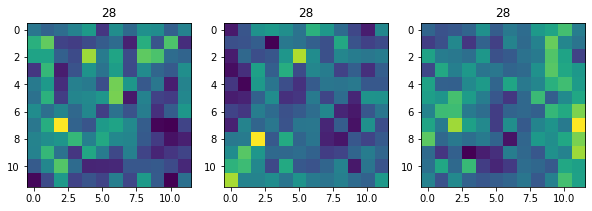

<Figure size 432x288 with 0 Axes>

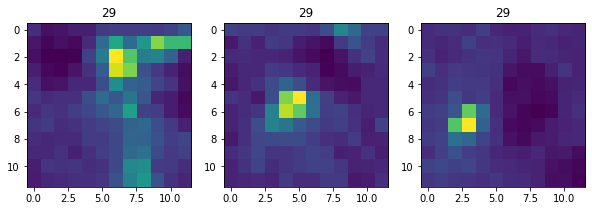

<Figure size 432x288 with 0 Axes>

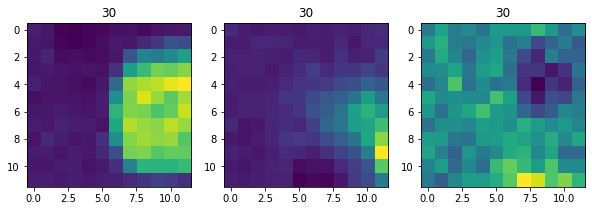

<Figure size 432x288 with 0 Axes>

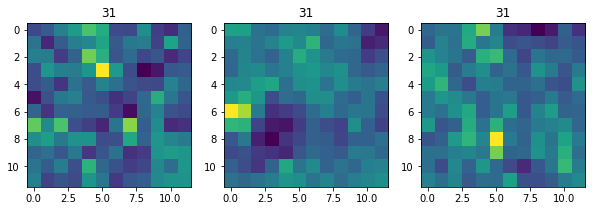

<Figure size 432x288 with 0 Axes>

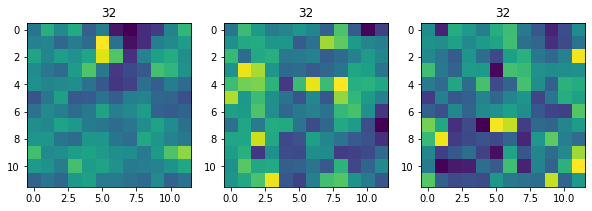

<Figure size 432x288 with 0 Axes>

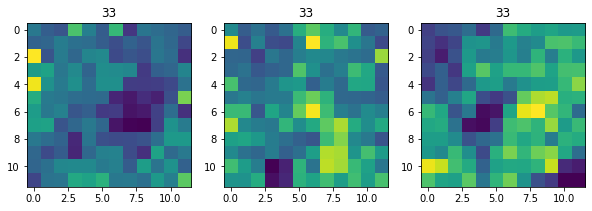

<Figure size 432x288 with 0 Axes>

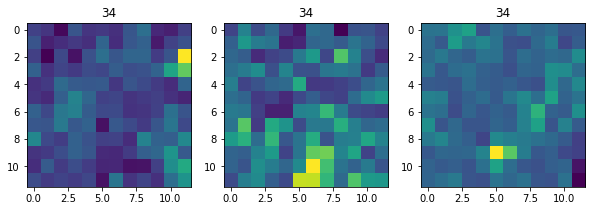

<Figure size 432x288 with 0 Axes>

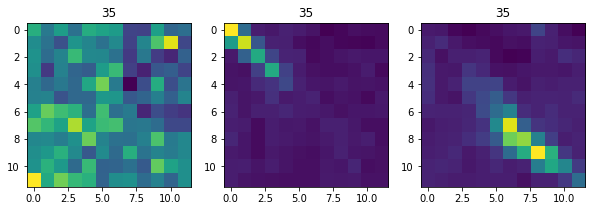

<Figure size 432x288 with 0 Axes>

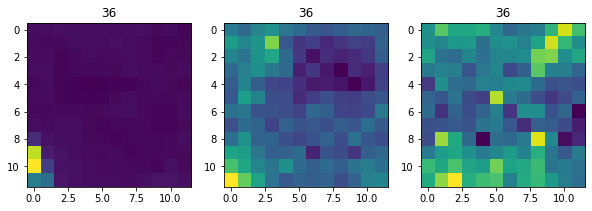

<Figure size 432x288 with 0 Axes>

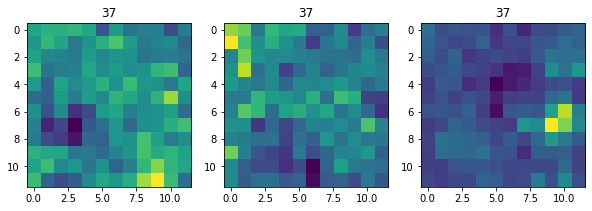

<Figure size 432x288 with 0 Axes>

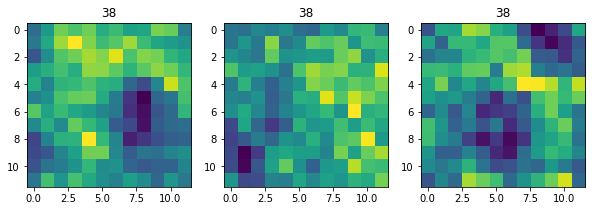

<Figure size 432x288 with 0 Axes>

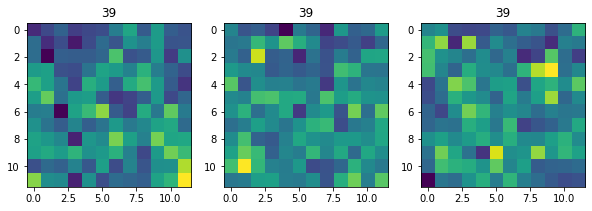

<Figure size 432x288 with 0 Axes>

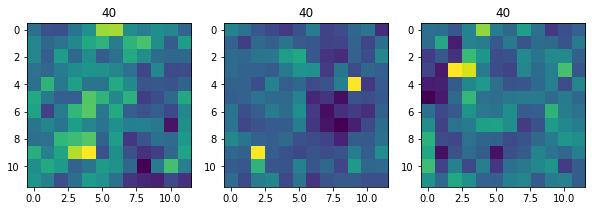

<Figure size 432x288 with 0 Axes>

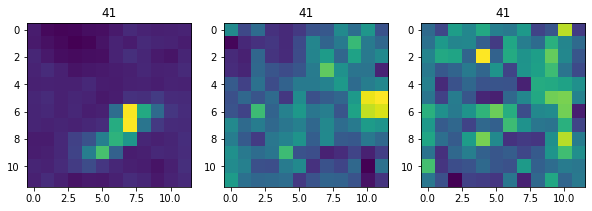

<Figure size 432x288 with 0 Axes>

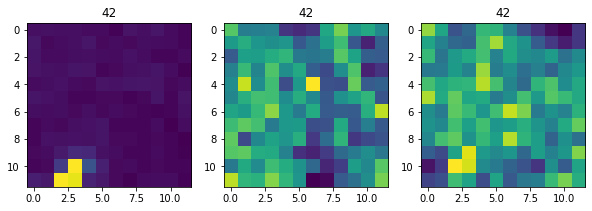

<Figure size 432x288 with 0 Axes>

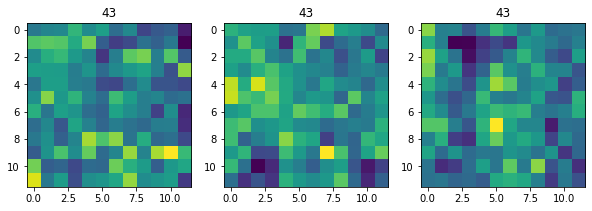

<Figure size 432x288 with 0 Axes>

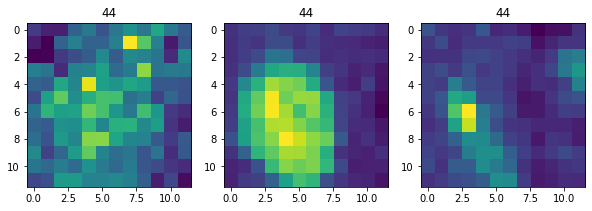

<Figure size 432x288 with 0 Axes>

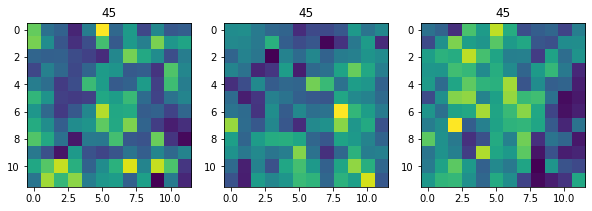

<Figure size 432x288 with 0 Axes>

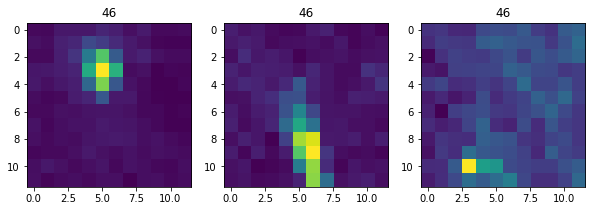

<Figure size 432x288 with 0 Axes>

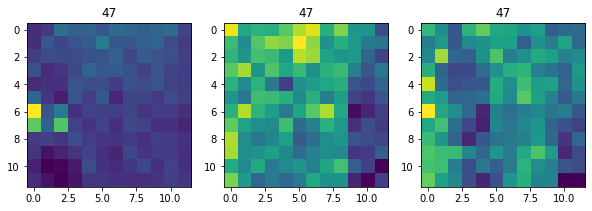

<Figure size 432x288 with 0 Axes>

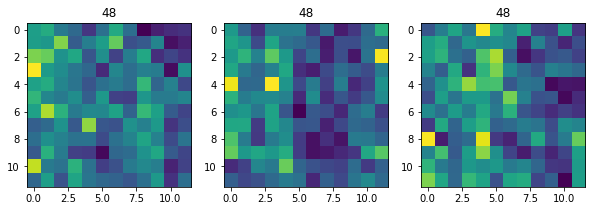

<Figure size 432x288 with 0 Axes>

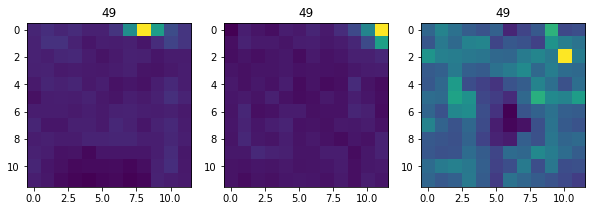

<Figure size 432x288 with 0 Axes>

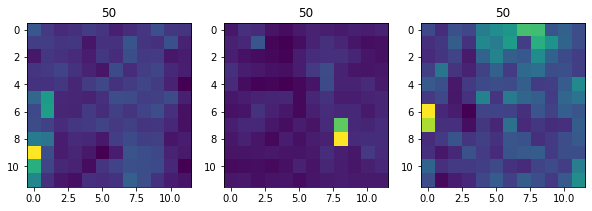

<Figure size 432x288 with 0 Axes>

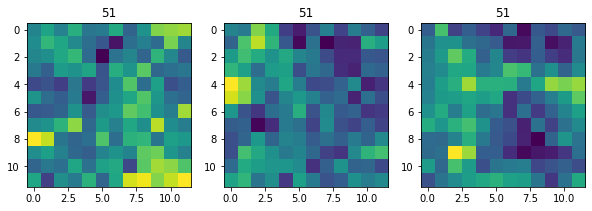

<Figure size 432x288 with 0 Axes>

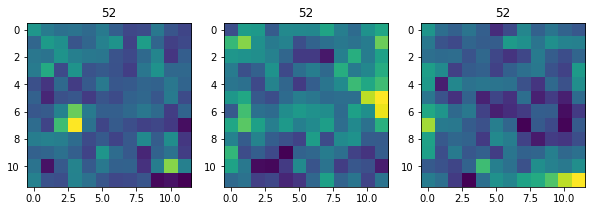

<Figure size 432x288 with 0 Axes>

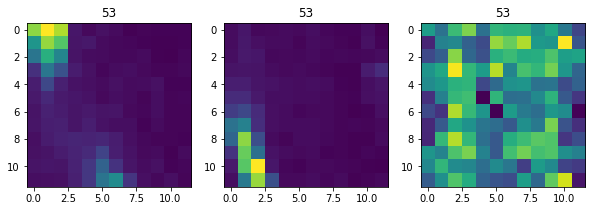

<Figure size 432x288 with 0 Axes>

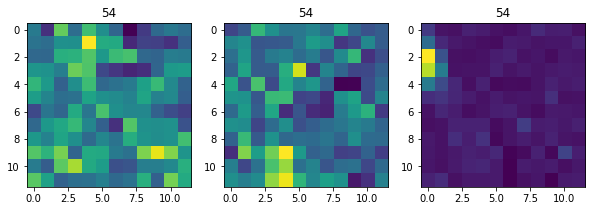

<Figure size 432x288 with 0 Axes>

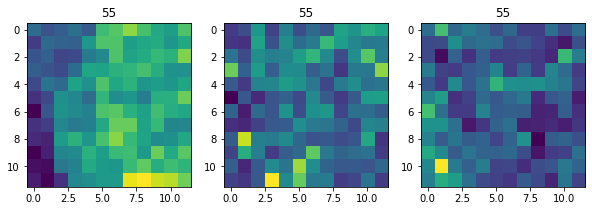

<Figure size 432x288 with 0 Axes>

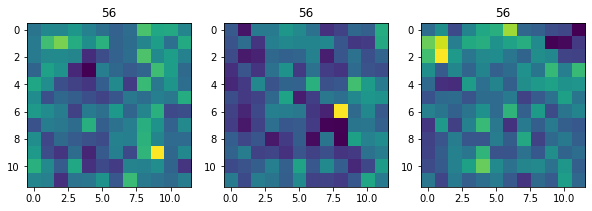

<Figure size 432x288 with 0 Axes>

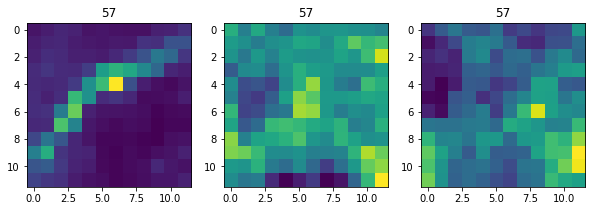

<Figure size 432x288 with 0 Axes>

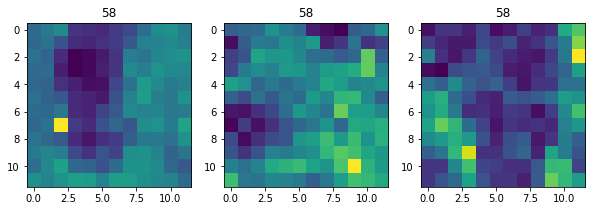

<Figure size 432x288 with 0 Axes>

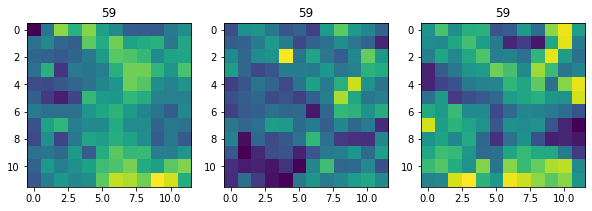

<Figure size 432x288 with 0 Axes>

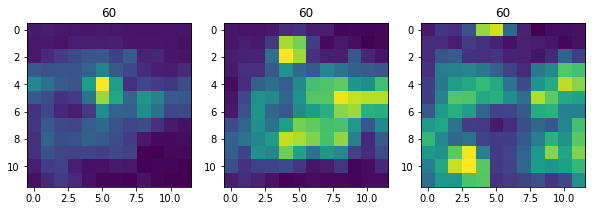

<Figure size 432x288 with 0 Axes>

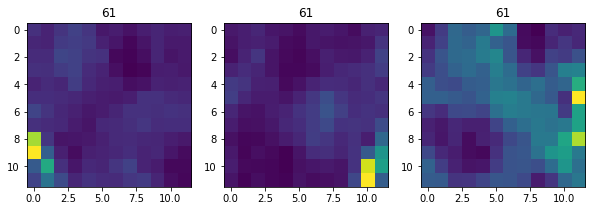

<Figure size 432x288 with 0 Axes>

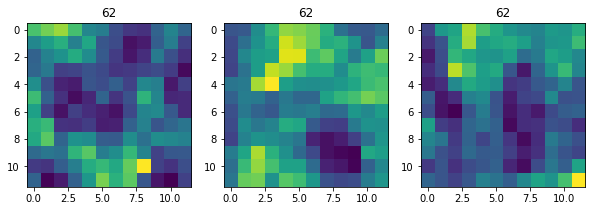

<Figure size 432x288 with 0 Axes>

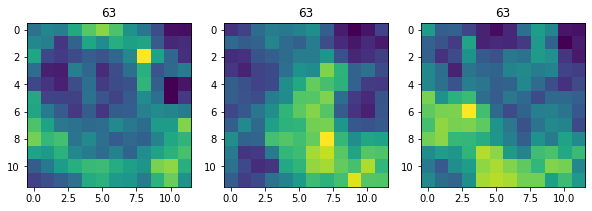

<Figure size 432x288 with 0 Axes>

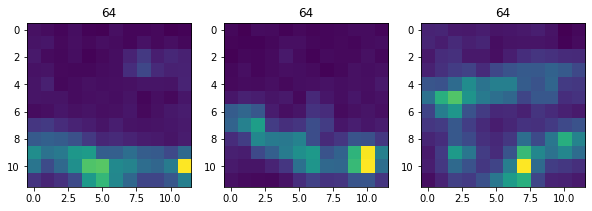

<Figure size 432x288 with 0 Axes>

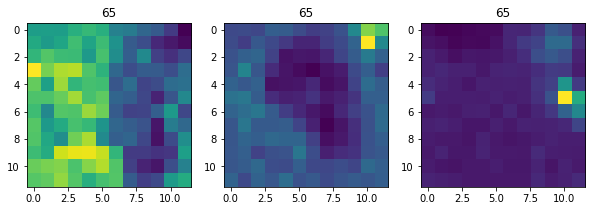

<Figure size 432x288 with 0 Axes>

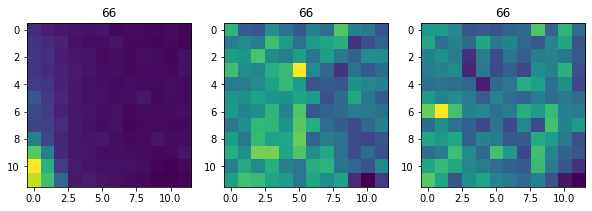

<Figure size 432x288 with 0 Axes>

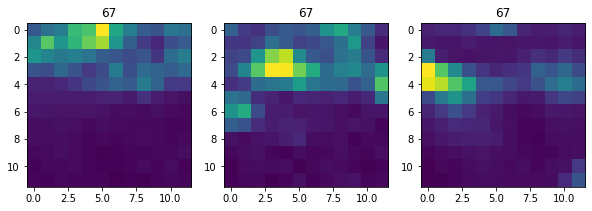

<Figure size 432x288 with 0 Axes>

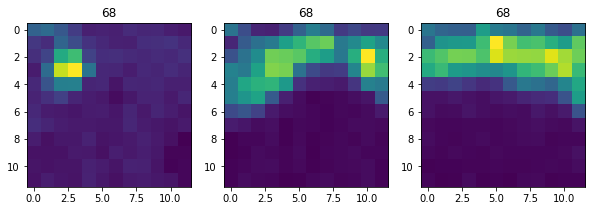

<Figure size 432x288 with 0 Axes>

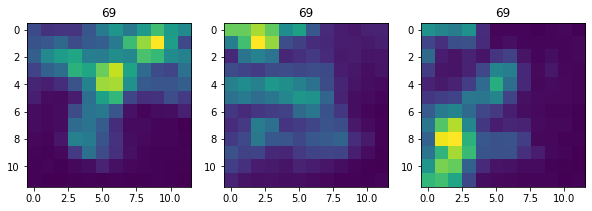

<Figure size 432x288 with 0 Axes>

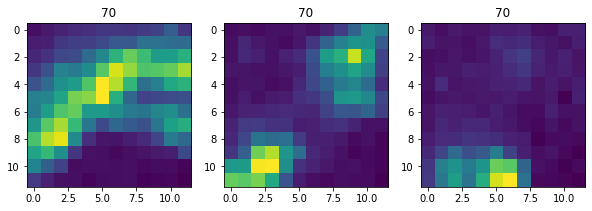

<Figure size 432x288 with 0 Axes>

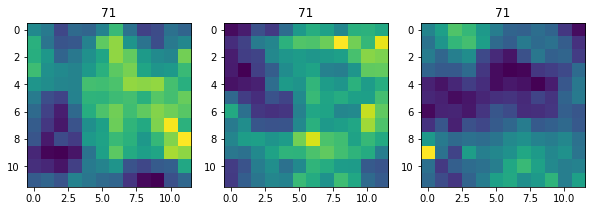

<Figure size 432x288 with 0 Axes>

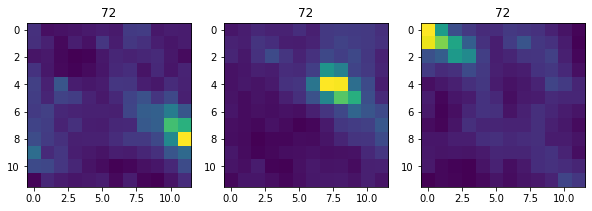

<Figure size 432x288 with 0 Axes>

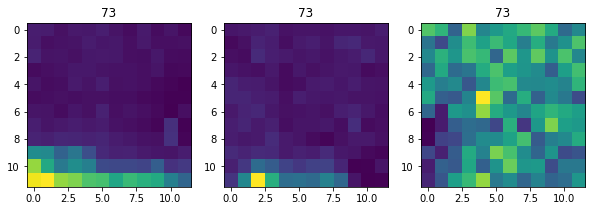

<Figure size 432x288 with 0 Axes>

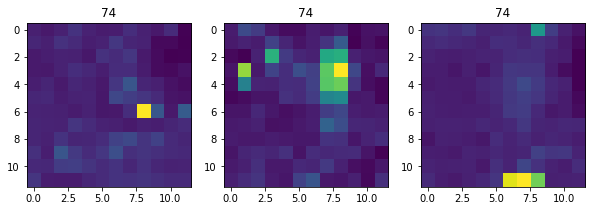

<Figure size 432x288 with 0 Axes>

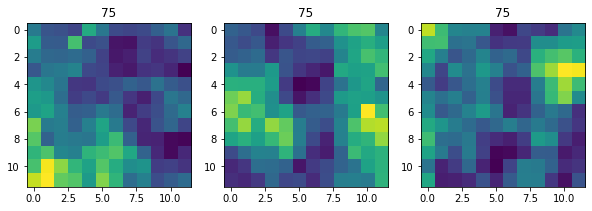

<Figure size 432x288 with 0 Axes>

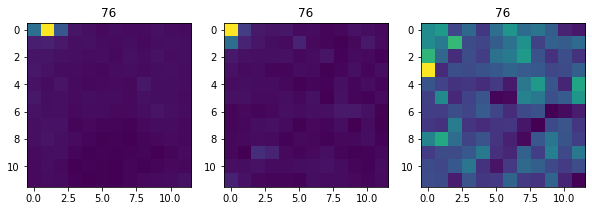

<Figure size 432x288 with 0 Axes>

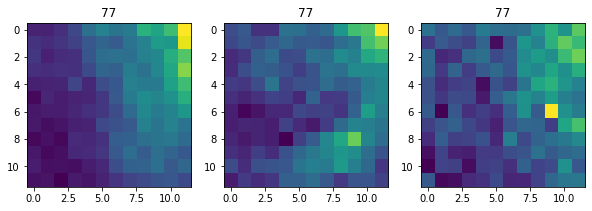

<Figure size 432x288 with 0 Axes>

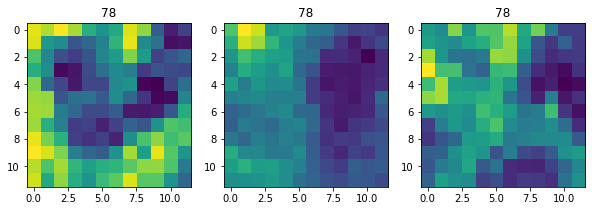

<Figure size 432x288 with 0 Axes>

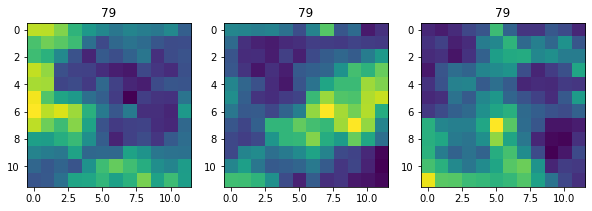

<Figure size 432x288 with 0 Axes>

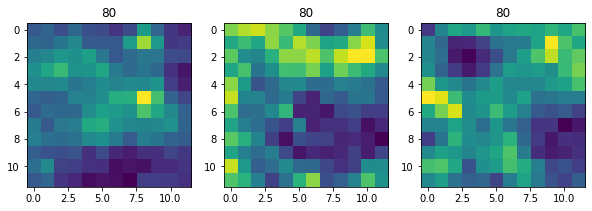

<Figure size 432x288 with 0 Axes>

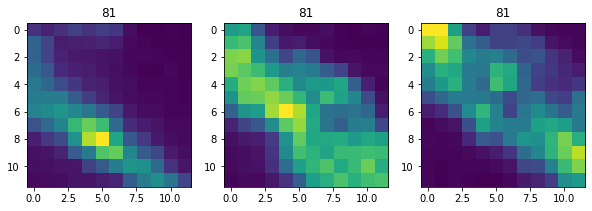

<Figure size 432x288 with 0 Axes>

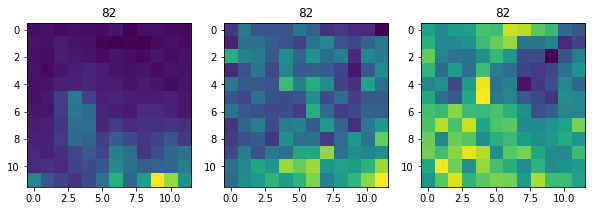

<Figure size 432x288 with 0 Axes>

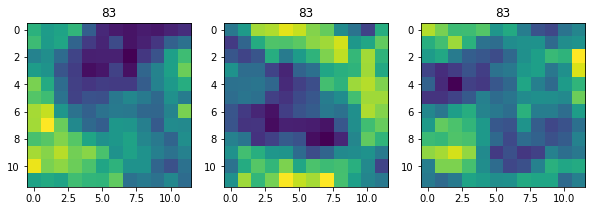

<Figure size 432x288 with 0 Axes>

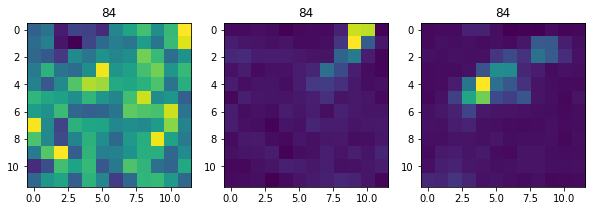

<Figure size 432x288 with 0 Axes>

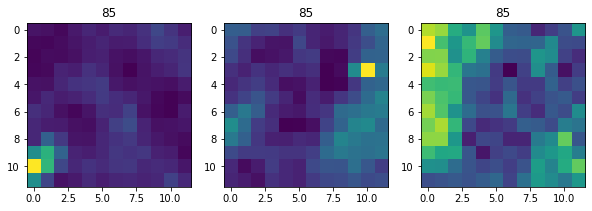

<Figure size 432x288 with 0 Axes>

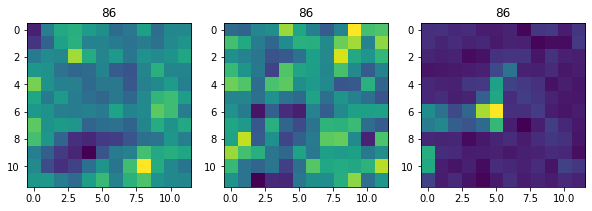

<Figure size 432x288 with 0 Axes>

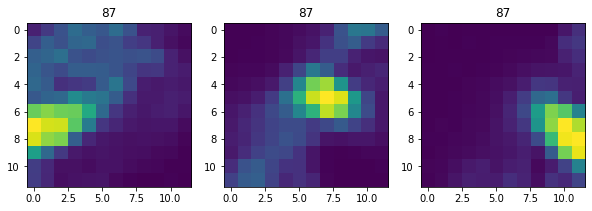

<Figure size 432x288 with 0 Axes>

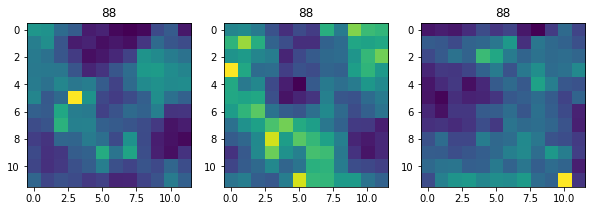

<Figure size 432x288 with 0 Axes>

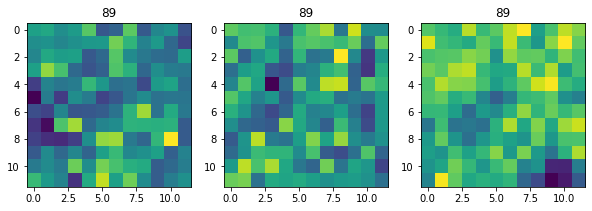

<Figure size 432x288 with 0 Axes>

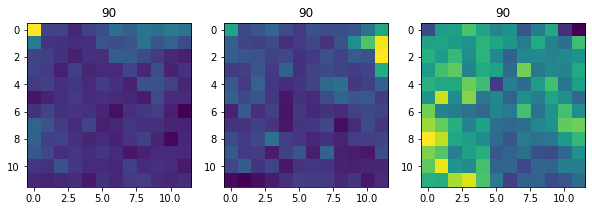

<Figure size 432x288 with 0 Axes>

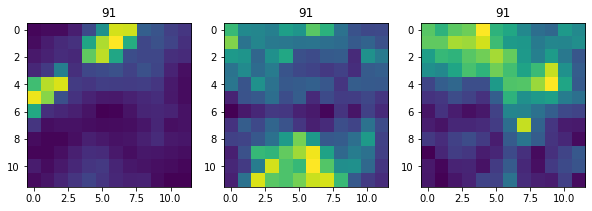

<Figure size 432x288 with 0 Axes>

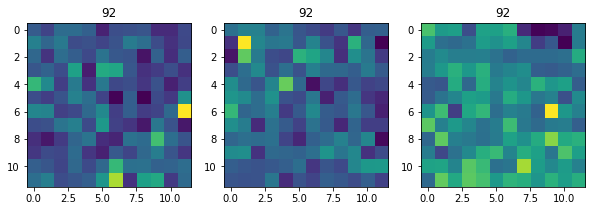

<Figure size 432x288 with 0 Axes>

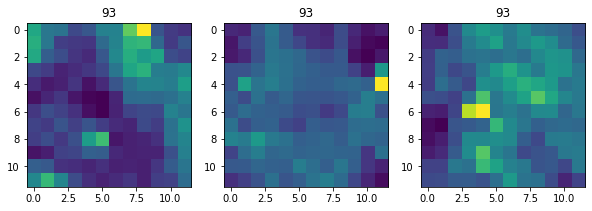

<Figure size 432x288 with 0 Axes>

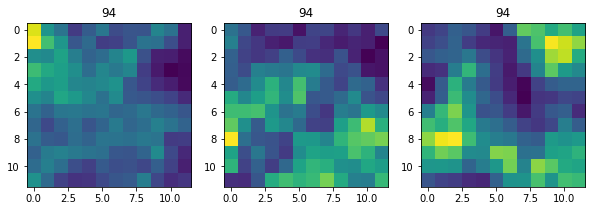

<Figure size 432x288 with 0 Axes>

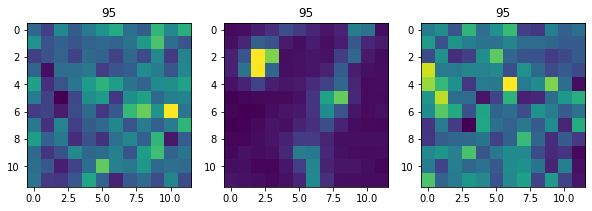

<Figure size 432x288 with 0 Axes>

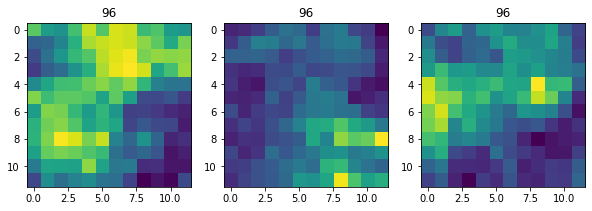

<Figure size 432x288 with 0 Axes>

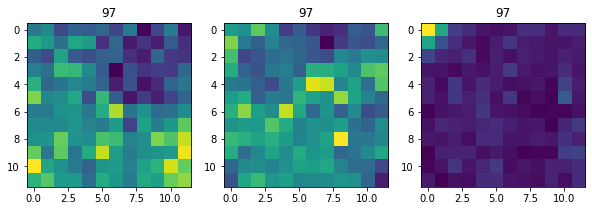

<Figure size 432x288 with 0 Axes>

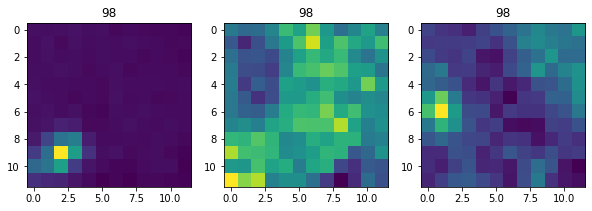

<Figure size 432x288 with 0 Axes>

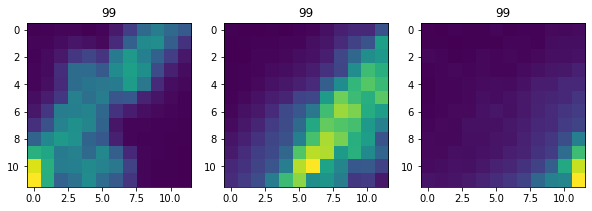

<Figure size 432x288 with 0 Axes>

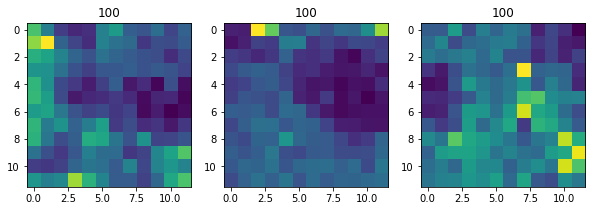

<Figure size 432x288 with 0 Axes>

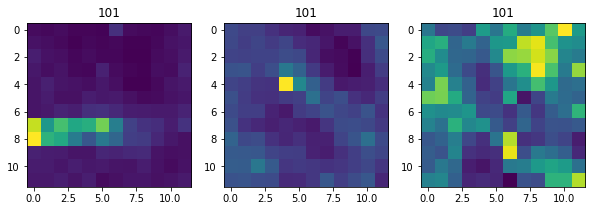

<Figure size 432x288 with 0 Axes>

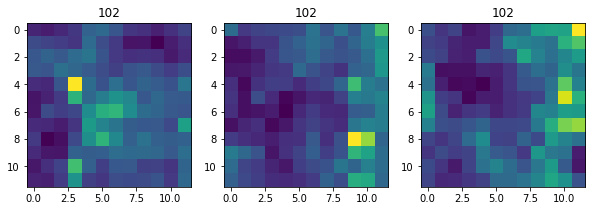

<Figure size 432x288 with 0 Axes>

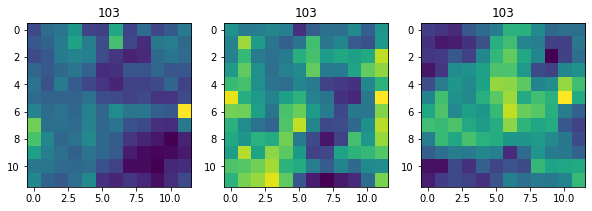

<Figure size 432x288 with 0 Axes>

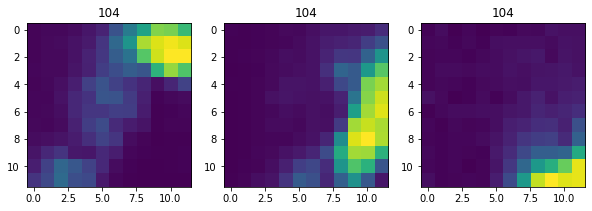

<Figure size 432x288 with 0 Axes>

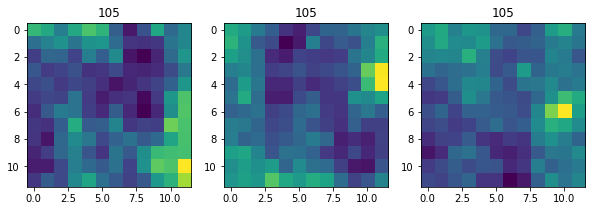

<Figure size 432x288 with 0 Axes>

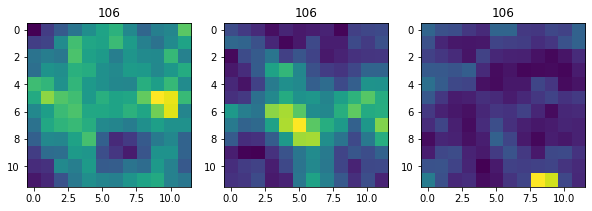

<Figure size 432x288 with 0 Axes>

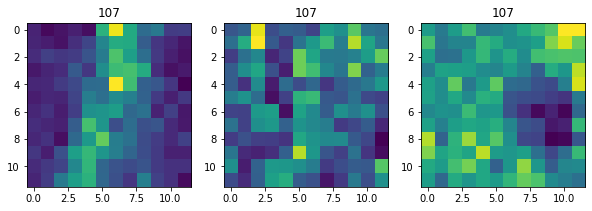

<Figure size 432x288 with 0 Axes>

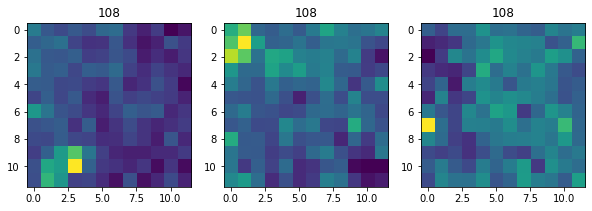

<Figure size 432x288 with 0 Axes>

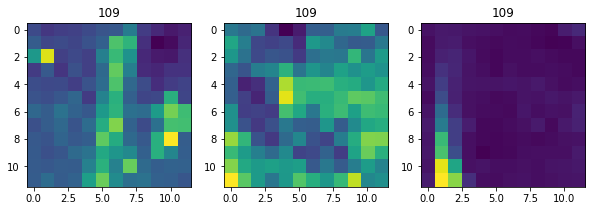

<Figure size 432x288 with 0 Axes>

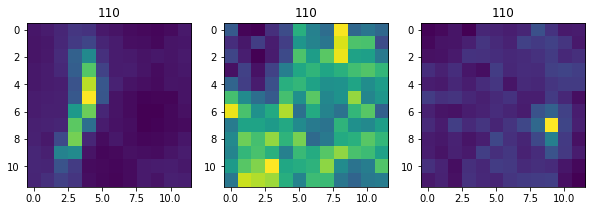

<Figure size 432x288 with 0 Axes>

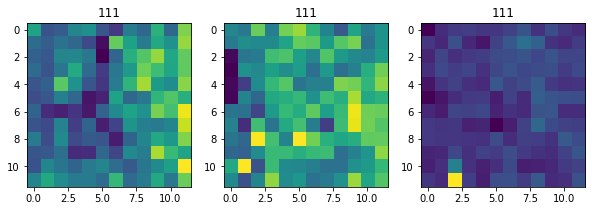

<Figure size 432x288 with 0 Axes>

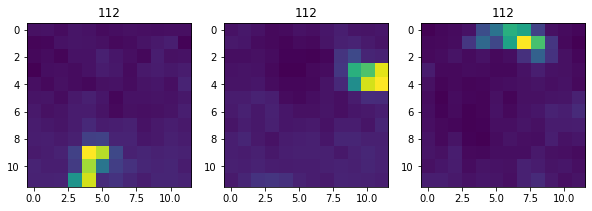

<Figure size 432x288 with 0 Axes>

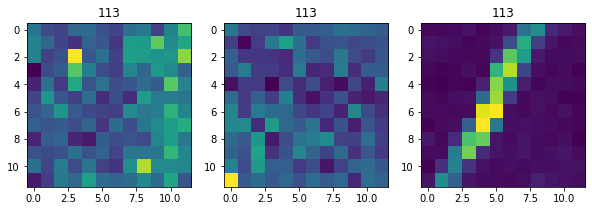

<Figure size 432x288 with 0 Axes>

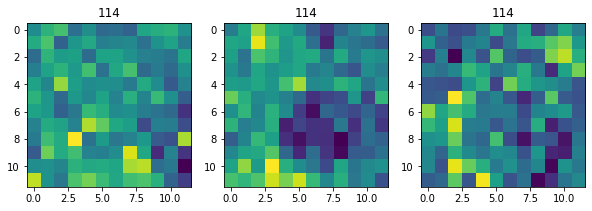

<Figure size 432x288 with 0 Axes>

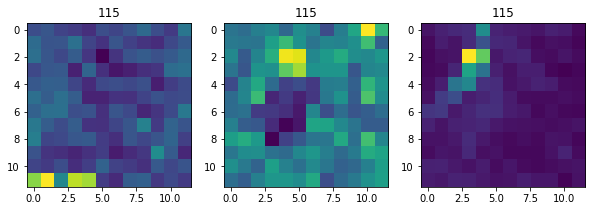

<Figure size 432x288 with 0 Axes>

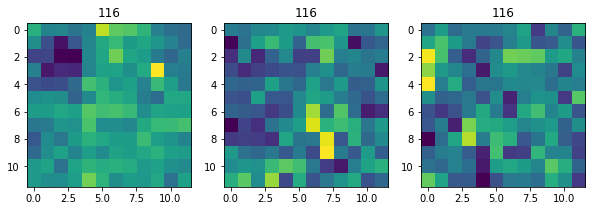

<Figure size 432x288 with 0 Axes>

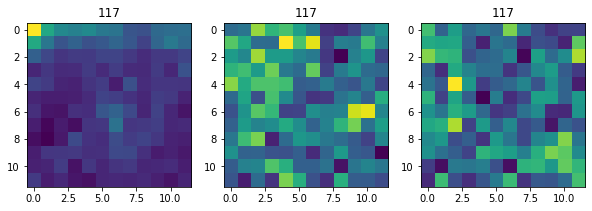

<Figure size 432x288 with 0 Axes>

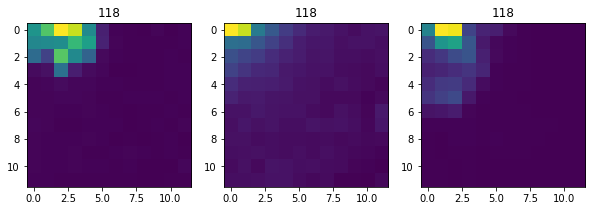

<Figure size 432x288 with 0 Axes>

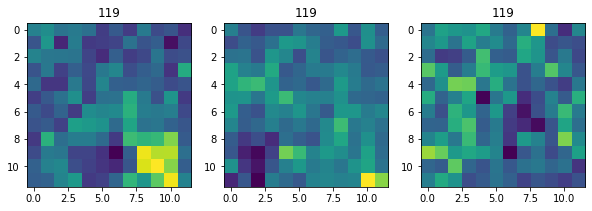

<Figure size 432x288 with 0 Axes>

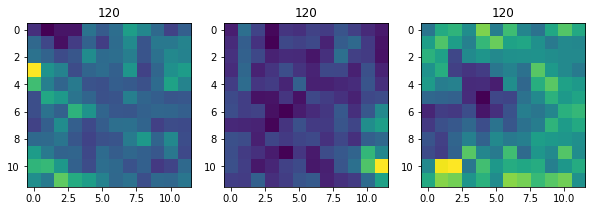

<Figure size 432x288 with 0 Axes>

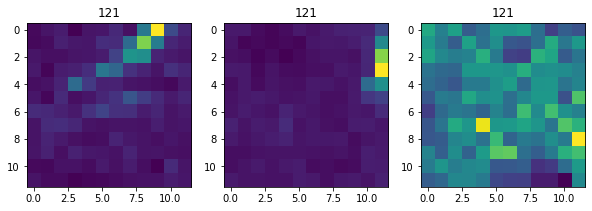

<Figure size 432x288 with 0 Axes>

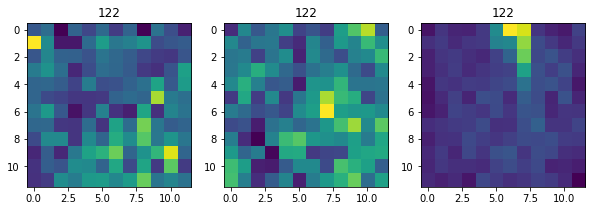

<Figure size 432x288 with 0 Axes>

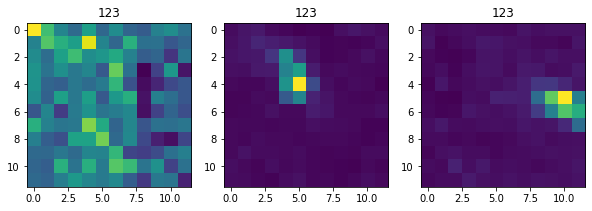

<Figure size 432x288 with 0 Axes>

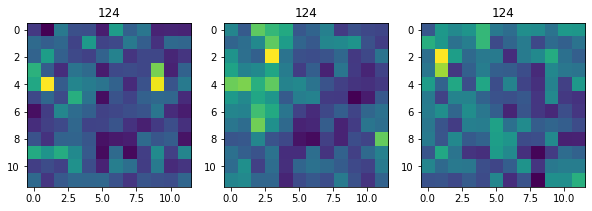

<Figure size 432x288 with 0 Axes>

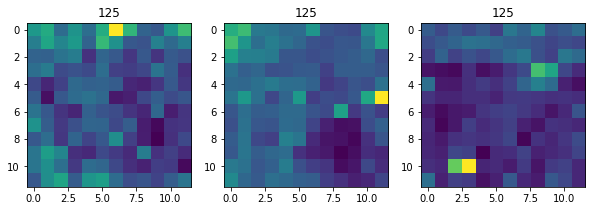

<Figure size 432x288 with 0 Axes>

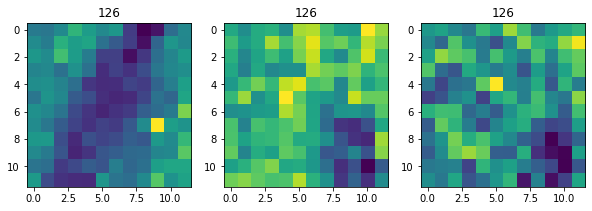

<Figure size 432x288 with 0 Axes>

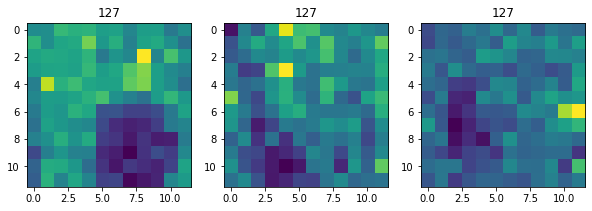

<Figure size 432x288 with 0 Axes>

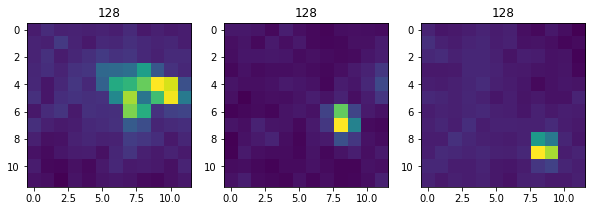

<Figure size 432x288 with 0 Axes>

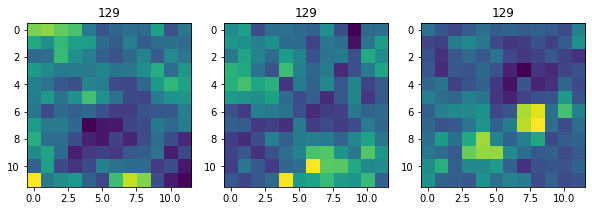

<Figure size 432x288 with 0 Axes>

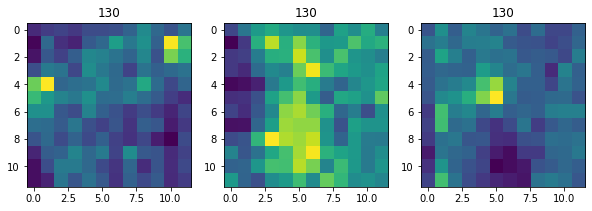

<Figure size 432x288 with 0 Axes>

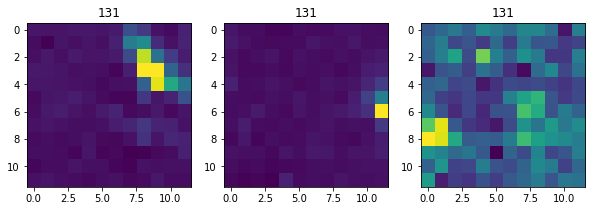

<Figure size 432x288 with 0 Axes>

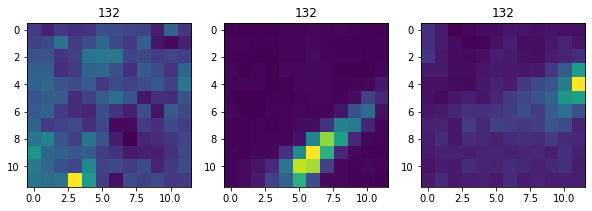

<Figure size 432x288 with 0 Axes>

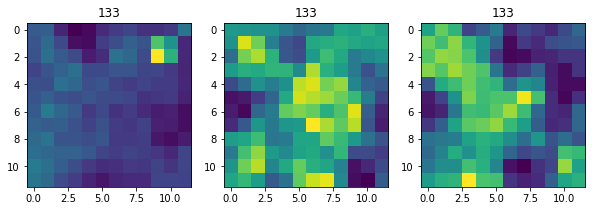

<Figure size 432x288 with 0 Axes>

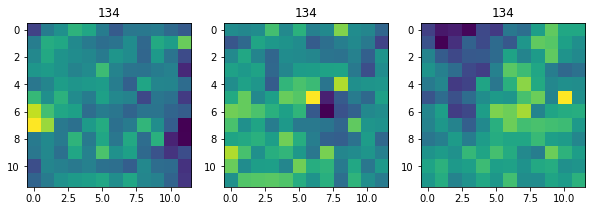

<Figure size 432x288 with 0 Axes>

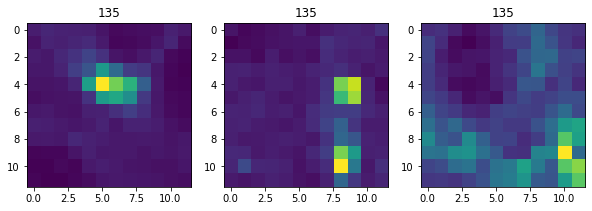

<Figure size 432x288 with 0 Axes>

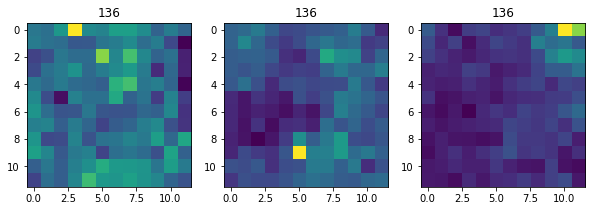

<Figure size 432x288 with 0 Axes>

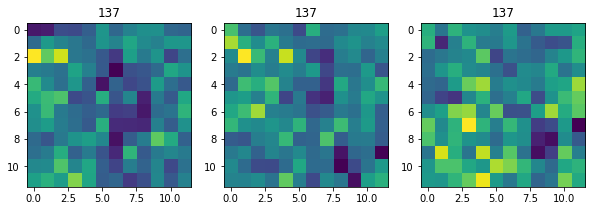

<Figure size 432x288 with 0 Axes>

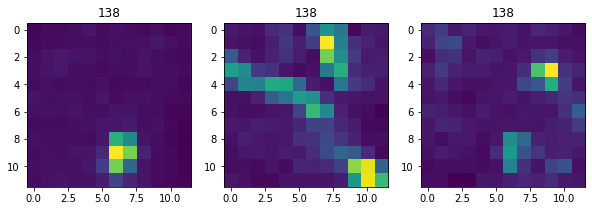

<Figure size 432x288 with 0 Axes>

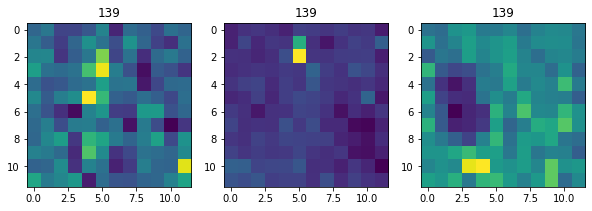

<Figure size 432x288 with 0 Axes>

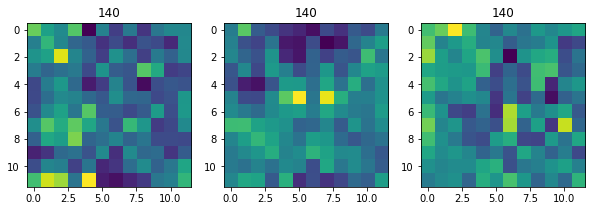

<Figure size 432x288 with 0 Axes>

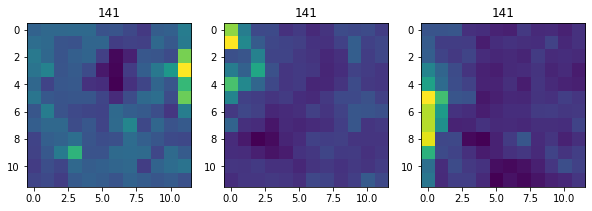

<Figure size 432x288 with 0 Axes>

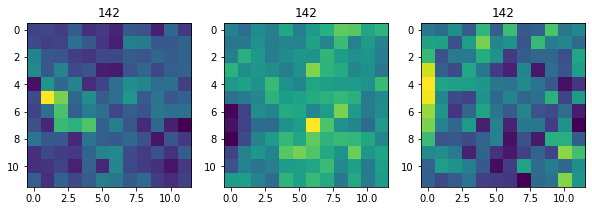

<Figure size 432x288 with 0 Axes>

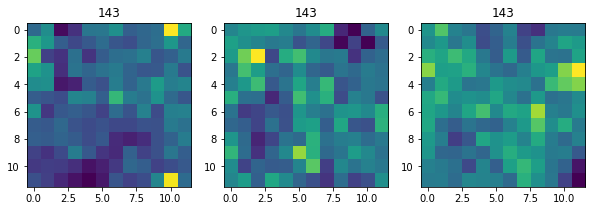

<Figure size 432x288 with 0 Axes>

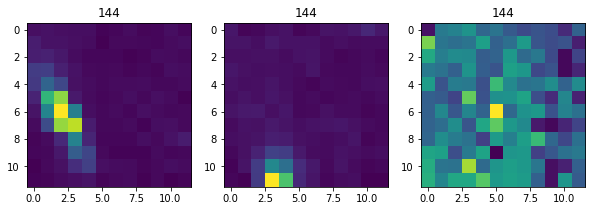

<Figure size 432x288 with 0 Axes>

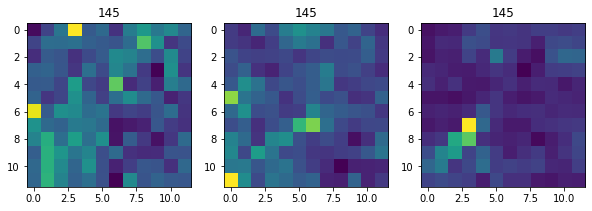

<Figure size 432x288 with 0 Axes>

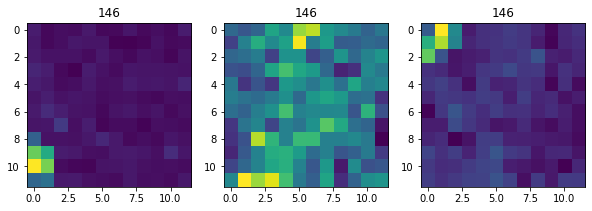

<Figure size 432x288 with 0 Axes>

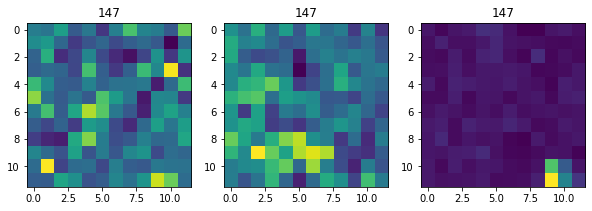

<Figure size 432x288 with 0 Axes>

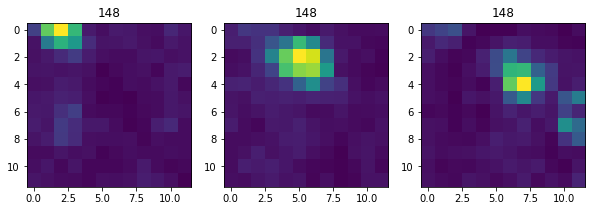

<Figure size 432x288 with 0 Axes>

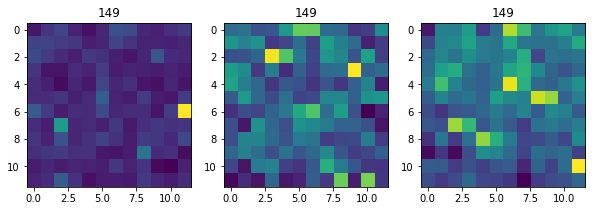

<Figure size 432x288 with 0 Axes>

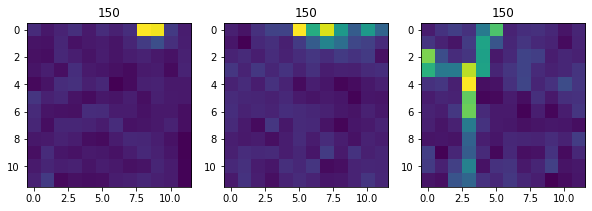

<Figure size 432x288 with 0 Axes>

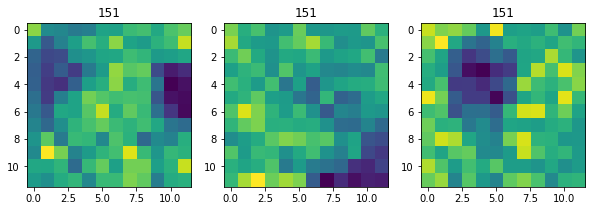

<Figure size 432x288 with 0 Axes>

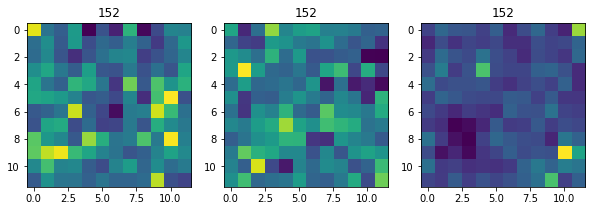

<Figure size 432x288 with 0 Axes>

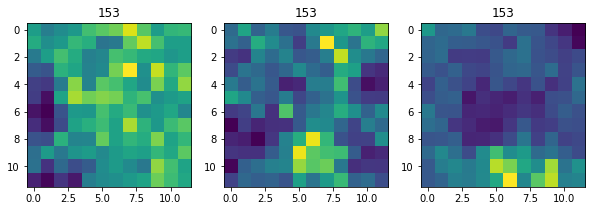

<Figure size 432x288 with 0 Axes>

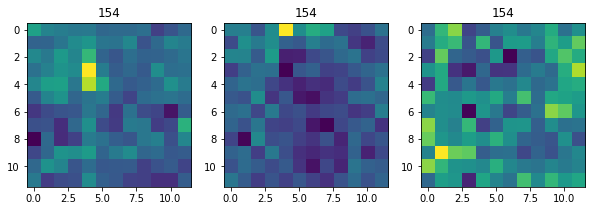

<Figure size 432x288 with 0 Axes>

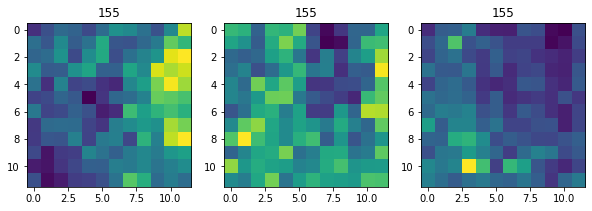

<Figure size 432x288 with 0 Axes>

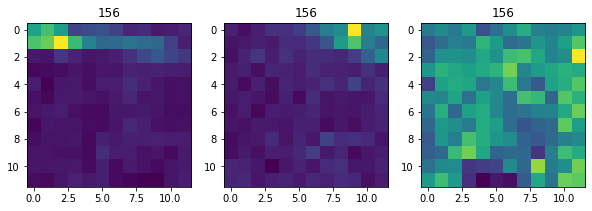

<Figure size 432x288 with 0 Axes>

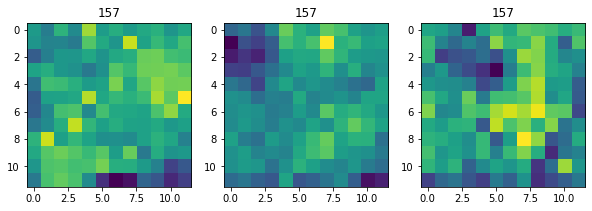

<Figure size 432x288 with 0 Axes>

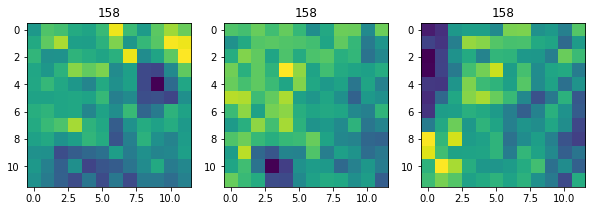

<Figure size 432x288 with 0 Axes>

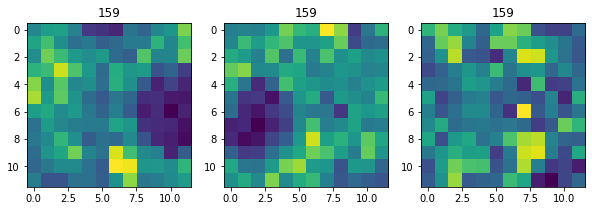

<Figure size 432x288 with 0 Axes>

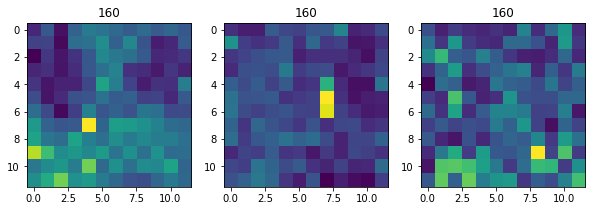

<Figure size 432x288 with 0 Axes>

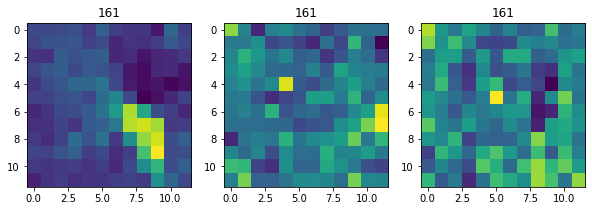

<Figure size 432x288 with 0 Axes>

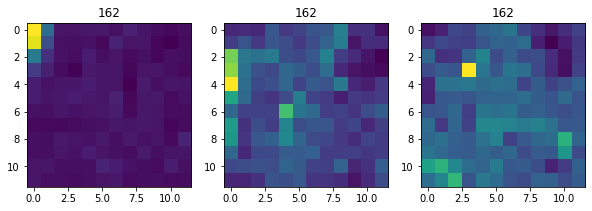

<Figure size 432x288 with 0 Axes>

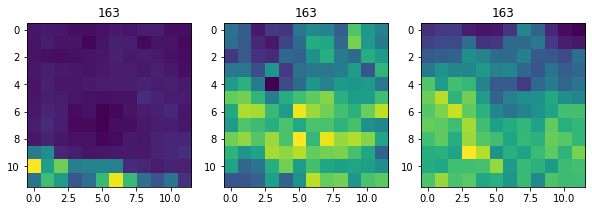

<Figure size 432x288 with 0 Axes>

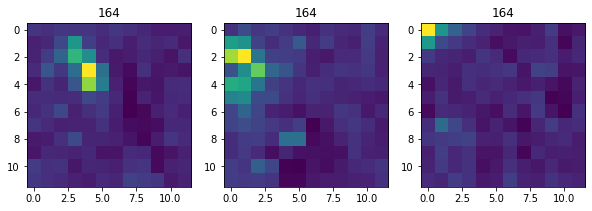

<Figure size 432x288 with 0 Axes>

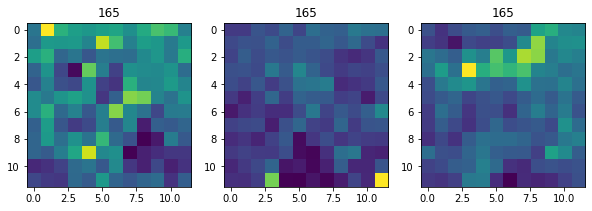

<Figure size 432x288 with 0 Axes>

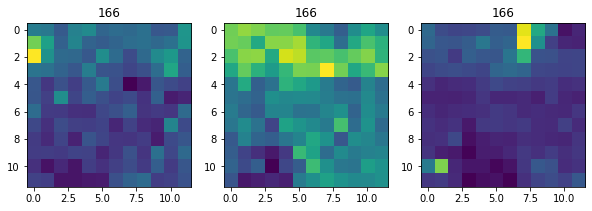

<Figure size 432x288 with 0 Axes>

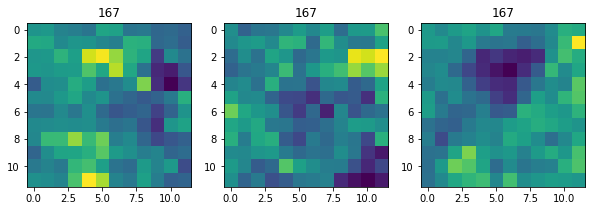

<Figure size 432x288 with 0 Axes>

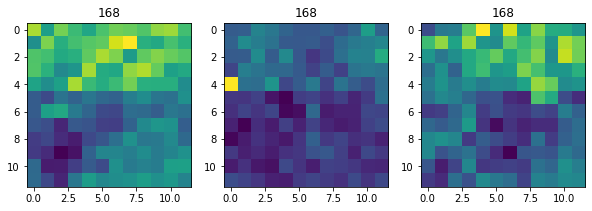

<Figure size 432x288 with 0 Axes>

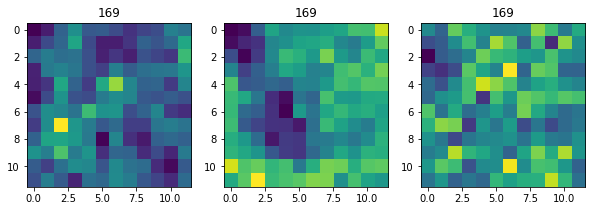

<Figure size 432x288 with 0 Axes>

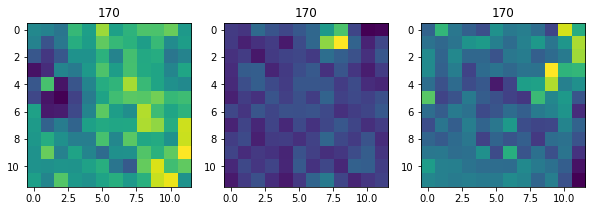

<Figure size 432x288 with 0 Axes>

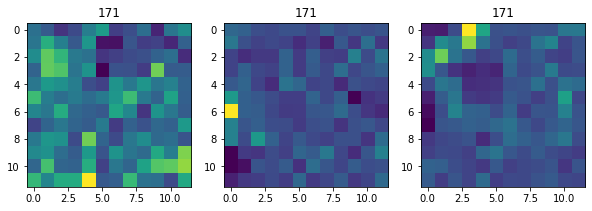

<Figure size 432x288 with 0 Axes>

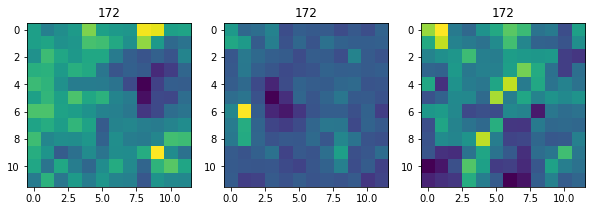

<Figure size 432x288 with 0 Axes>

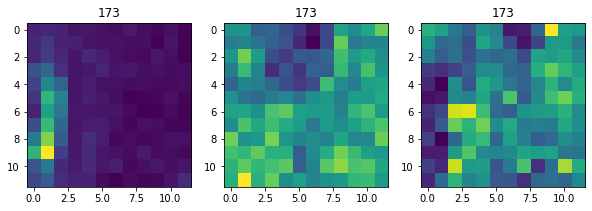

<Figure size 432x288 with 0 Axes>

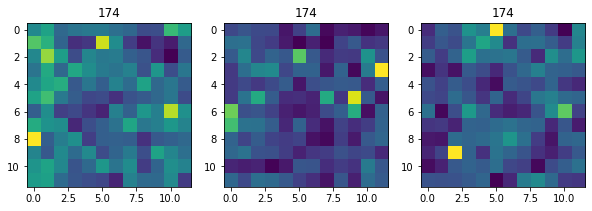

<Figure size 432x288 with 0 Axes>

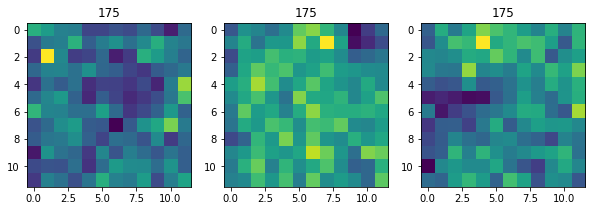

<Figure size 432x288 with 0 Axes>

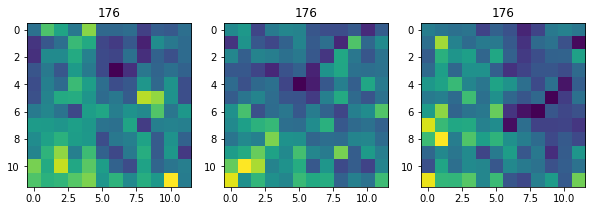

<Figure size 432x288 with 0 Axes>

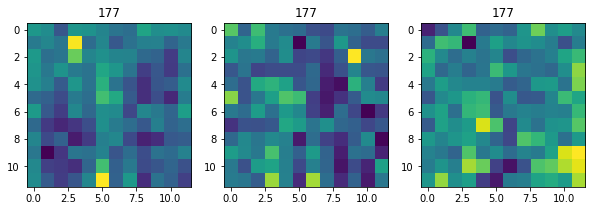

<Figure size 432x288 with 0 Axes>

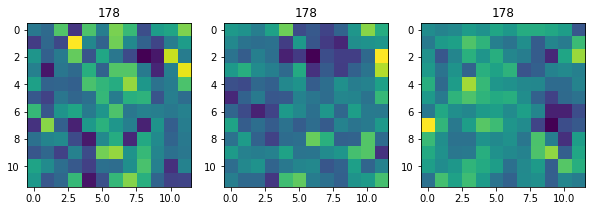

<Figure size 432x288 with 0 Axes>

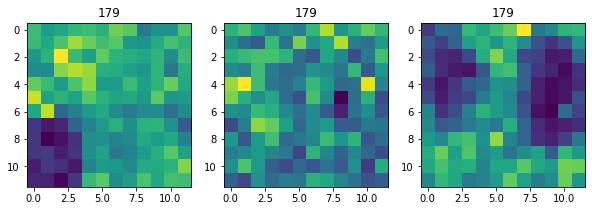

In [18]:
for i in range(len(NCR_imgs)):
    fig = plt.figure()
    f, axarr = plt.subplots(1,3, figsize=(10,10) ) 
    axarr[0].set_title(i); axarr[1].set_title(i); axarr[2].set_title(i)

    axarr[0].imshow(NCR_imgs[i][:,:,3])
    axarr[1].imshow(NCR_imgs[i][:,:,6])
    axarr[2].imshow(NCR_imgs[i][:,:,9])

## Closely inspect any regions that look like they may contain cells

In [49]:
%gui qt
i = 104
# path = paths[i]
with napari.gui_qt():
    viewer = napari.Viewer(ndisplay=3)
    viewer.add_image( NCR_imgs[i] )

## Remove any volumes that may include a cell body (values will change per dataset)

In [50]:
for i in [30 ,44-1, 67-2]:
    NCR_imgs.pop(i)

In [51]:
np.save('NCR_all_bias_corrected.npy', NCR_imgs)

 # *Test model on current dataset*

## Combine ROIs and NCRs into single stack

In [62]:
ROI_TEST = np.load('ROI_all_bias_corrected.npy')
print("Total Number of Cell Regions: ", len(ROI_TEST))

NCR_TEST = np.load('NCR_all_bias_corrected.npy')
print("Number of Non-Cell Regions:",len(NCR_TEST))

ROI_TEST = ROI_TEST.astype(np.float32)
print(ROI_TEST.shape)
NCR_TEST = NCR_TEST.astype(np.float32)
print(NCR_TEST.shape)

test = np.vstack((ROI_TEST, NCR_TEST))

print("Number of Items in Test Data: %s" %len(test))
test = np.expand_dims(test, axis=1)
print('Shape of Test Data Vector:', test.shape)

Total Number of Cell Regions:  180
Number of Non-Cell Regions: 177
(180, 12, 12, 12)
(177, 12, 12, 12)
Number of Items in Test Data: 357
Shape of Test Data Vector: (357, 1, 12, 12, 12)


## Build Neural Net Class

In [64]:
# m1 = torch.load('model2.pt')
# 1. Model Architecture
# INPUT: 
# - 1 x 12 x 12 x 12 image
# CONV1: 3d CONV
# MAXPOOL: 3d MP
# CONV2: 3d CONV
# CONV3: 3d CONV
# FC1: Fully Connected Layer
# FC2: Fully Connected Layer

class M1(nn.Module):
    def __init__(self):
        super(M1, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv3d(1,64, (5,5,5),padding = 2),nn.Dropout(dr)) # in_channel, out_channel, kernel
        self.pool = nn.MaxPool3d((2, 2, 2),2) # kernel, stride
        self.conv2 = nn.Sequential(nn.Conv3d(64, 64, (3,3,3), padding = 1), nn.Dropout(dr)) # in_channel, out_channel, kernel
        self.conv3 = nn.Sequential(nn.Conv3d(64, 64, (3,3,3), padding = 1), nn.Dropout(dr)) # in_channel, out_channel, kernel
        self.fc1 = nn.Sequential(nn.Linear(6*6*6*64,150),nn.Dropout(dr))
        self.fc2 = nn.Sequential(nn.Linear(150,1),nn.Dropout(dr))

    def forward(self,x):
#        print('Input Shape: ', x.shape)
        x = F.relu(self.conv1(x))
#        print('Shape after CONV1: ', x.shape)
        # Conv1 Activation: ReLU
        x = self.pool(x)
#         print('Shape after Maxpool: ', x.shape)
        # Followed by Maxpool
     
        x = F.relu(self.conv2(x))
#         print('Shape after CONV2: ', x.shape)
        # Conv2 Activation: ReLU
        
        x = F.relu(self.conv3(x))
#         print('Shape after CONV3: ', x.shape)
        # Conv3 Activation: ReLU
        
        x = x.reshape(x.size(0),-1)
#         print('Shape after flatten: ', x.shape)
        # flatten vector
              
        x = F.relu(self.fc1(x))
        # FC1 Activation: ReLU
#         print('Shape after FC1: ', x.shape)
        x = self.fc2(x)
        # FC2 Activation: None
#         print('Shape after FC2: ', x.shape)
        m = nn.Sigmoid()
#         print('Shape after Sigmoid Output: ', x.shape)

        x = m(x)
        # Output Activation: Sigmoid
        return x

#Hyperparamters
num_epochs = 200
batch_size = 5
learning_rate = 1e-3
momentum = 0.9
dr = 0.3
weight_decay = 1e-4
m1 = M1()

## Load pre-trained model

In [65]:
m1 = M1()
m1.load_state_dict(torch.load('crossvalidation4.pt', map_location = torch.device('cpu') ))
m1 = m1.double()

## Build array of ground truth pos/neg values, preprocess data to appropriate pyTorch format, and run m1 model on data

In [66]:
truelabels = []
for i in range(ROI_TEST.shape[0] ):
    truelabels.append(1)
for i in range(NCR_TEST.shape[0]):
    truelabels.append(0)
    
labels=[]
for i in range(len(test)):
    w = torch.from_numpy(test[i])
    w = w.unsqueeze(1)
    w = w.double()
    w = m1(w)
    labels.append(w.detach().numpy())

truelabels = np.asarray(truelabels)
labels = np.asarray(labels)
labels = labels.squeeze()

## Compute False/Positive Rate and True/Positive Rate using Receiver Operating Characteristics and Precision Recall pairs

In [67]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(truelabels, labels)
mets = sklearn.metrics.precision_recall_curve(truelabels, labels, pos_label=None, sample_weight=None)
#np.save('positivecells.npy',positivecells)

# *Results*

## Asssess accuracy with Area Under Curve score

In [68]:
auc = sklearn.metrics.roc_auc_score(truelabels, labels)
print('AUC: %.3f' % auc)

AUC: 0.859


# Plot False/Positive Rate vs. True/Positive Rate

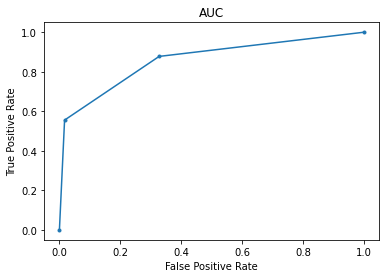

In [69]:
plt.plot(fpr, tpr, marker='.')
plt.title("AUC")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the plot
plt.show()

# Calculate and plot F1 score using Recall vs. Precision

In [70]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(truelabels, labels)
auc = sklearn.metrics.auc(recall, precision)

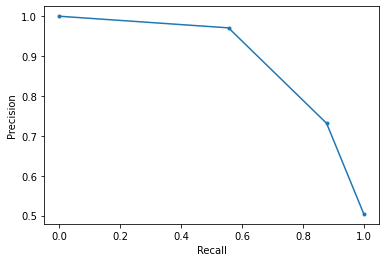

In [71]:
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# *Conclusion*

### Our results show a consistently high degree of accuracy when utilizing the Area Under Curve score as such a measure: between 85% and 90%. This confirms our hypothesis that this model generalizes well to other datasets and implies that it has the potential to be a useful methodological addition to the Brainlit package. Some possible improvements would be: (1) increase the model's input volume size from 12x12x12 (by retraining with larger subvolumes), and (2) consider retraining with additional data from our brains. 